In [1]:
from notebook_functions import *
from scipy.optimize import curve_fit

In [2]:
region="Wafrica"
MCS_data_dict={}
# Trop5-param
MCS_data_dict["Channel_GAL9"]=data_prep(region,"Channel_n2560_GAL9")
# Trop5-exp
MCS_data_dict["Channel_RAL3"]=data_prep(region,"Channel_n2560_RAL3p2")
# CP4-Af
MCS_data_dict["CP4"]=data_prep(region,"Cp4")
# LAM2.2
MCS_data_dict["Lam"]=data_prep(region,"Lam_km2p2_RAL3p2")
MCS_data_dict["OBS"]=data_prep("WAf","Obs")

In [3]:
for sim in list(MCS_data_dict.keys()):
    #try:
    #    MCS_data_dict[sim] = MCS_data_dict[sim][MCS_data_dict[sim]["q925"] >= 8]
    #except:
    #    pass
    
    MCS_data_dict[sim]=MCS_data_dict[sim][MCS_data_dict[sim].hour.isin(np.arange(16,22))]
    MCS_data_dict[sim]["ushear650_850"] = -1*MCS_data_dict[sim]["ushear650_850"]
    MCS_data_dict[sim]["ushear650_925"] = -1*MCS_data_dict[sim]["ushear650_925"]

    MCS_data_dict[sim]["rain_area_tot"]=(MCS_data_dict[sim]["rain_mean"]*MCS_data_dict[sim]["area"]).astype("float")
    if sim.upper()=="CP4":
        MCS_data_dict[sim]["rain_tot"]=MCS_data_dict[sim]["rain_mean"]*MCS_data_dict[sim]["area"]/(4.5**2)
    else:
        MCS_data_dict[sim]["rain_tot"]=MCS_data_dict[sim]["rain_mean"]*MCS_data_dict[sim]["area"]/(11.1**2)
        
    try:
        MCS_data_dict[sim]["rootCAPE"] = np.sqrt(MCS_data_dict[sim]["CAPE-6"])
    except:
        pass

In [4]:
MCS_data_dictw=MCS_data_dict.copy()
for sim in list(MCS_data_dictw.keys()):
    MCS_data_dictw[sim] = MCS_data_dictw[sim][MCS_data_dictw[sim].hour.isin([18,21])]

In [7]:
for sim in list(MCS_data_dict.keys()):
    print(sim)
    print(stats.pearsonr(MCS_data_dict[sim]["tcw"],MCS_data_dict[sim]["ushear650_850"]))

Channel_GAL9
PearsonRResult(statistic=0.1875842077647301, pvalue=5.2966046745293675e-14)
Channel_RAL3
PearsonRResult(statistic=-0.0029693247829560084, pvalue=0.8783643366773233)
CP4
PearsonRResult(statistic=-0.09634056058365582, pvalue=1.768480263001448e-91)
Lam
PearsonRResult(statistic=-0.026200216976932957, pvalue=0.1504227875452471)
OBS
PearsonRResult(statistic=-0.07673618175157876, pvalue=9.82045791982623e-87)


In [8]:
for sim in list(MCS_data_dict.keys()):
    print(sim)
    print(stats.pearsonr(MCS_data_dict[sim]["tcw"],MCS_data_dict[sim]["q850"]))

Channel_GAL9
PearsonRResult(statistic=-0.09010152747053173, pvalue=0.00033152369055984755)
Channel_RAL3
PearsonRResult(statistic=0.2662891755956573, pvalue=2.1234911714754173e-44)
CP4
PearsonRResult(statistic=-0.008664959663212547, pvalue=0.06873143316877285)
Lam
PearsonRResult(statistic=0.22899878212305264, pvalue=3.7110053777865045e-37)
OBS
PearsonRResult(statistic=0.2507306315117723, pvalue=0.0)


FIGURE 1

In [12]:
for sim in ["Channel_GAL9","Channel_RAL3","CP4","OBS"]:
    MCS_data=MCS_data_dict[sim]
    try:
        print(stats.pearsonr(MCS_data["tcw"][MCS_data["psfc"]>850],MCS_data["ushear650_850"][MCS_data["psfc"]>850]))
    except:
        try:
            print(stats.pearsonr(MCS_data["tcw"],MCS_data["ushear650_850"]))
        except:
            pass

PearsonRResult(statistic=0.1875842077647301, pvalue=5.2966046745293675e-14)
PearsonRResult(statistic=-0.0029693247829560084, pvalue=0.8783643366773233)
PearsonRResult(statistic=-0.09634056058365582, pvalue=1.768480263001448e-91)
PearsonRResult(statistic=-0.07673618175157876, pvalue=9.82045791982623e-87)


In [13]:
MCS_data=MCS_data_dict["OBS"]
print(stats.pearsonr(MCS_data["tcw"],MCS_data["q850"]))

PearsonRResult(statistic=0.2507306315117723, pvalue=0.0)


In [14]:
def hierarchy_var_comparison(MCS_data_dict,comp_var,region="Wafrica",full=False,moist_var="tcw",shear_var="ushear650_850",grid_spec=10,
                             cut_off=5,save=None,grid_spec2=None,min_pcle=0.01,max_pcle=0.99):
    utc_offset=0
    if full==True:
        hierarchy=["OBS","Channel_RAL3","Channel_GAL9","CP4","Lam"]
        fig,axes=plt.subplots(2,3,figsize=(13,9))
    else:
        hierarchy=["OBS","CP4","Channel_RAL3","Channel_GAL9"]
        fig,axes=plt.subplots(1,4,figsize=(16,4.5))
    #hierarchy=list(MCS_data_dict.keys())
    #fig,axes=plt.subplots(1,len(hierarchy),figsize=(4*len(hierarchy),4.5))
    
    for sim in hierarchy[:-1]:
        temp=MCS_data_dict[sim]
        try:
            plev=int(shear_var[-3:])
            try:
                plev=np.max(int(moist_var[-3:]),plev)
            except:
                pass
            temp=temp[temp["psfc"]>plev]
        except:
            pass
        MCS_data_dict[sim]=temp

    ylab=moist_var
    if moist_var[0]=="q":
        ylab="q%s (g kg$^{-1}$)" % (moist_var[-3:])
    elif moist_var=="tcw":
        ylab="TCW (mm)"
    try:
        xlab="u%s - u%s (ms$^{-1}$)"%(shear_var[6:9],shear_var[-3:])
    except:
        xlab=shear_var

    cmap="viridis"
    if comp_var=="rain_max" or "p9" in comp_var:
        bounds=np.arange(9,39,3)
        cmap,tit_str,lab="Blues","Maximum rainfall",r"mm hr$^{-1}$"
    elif comp_var=="rain_mean":
        bounds=np.arange(0.5,5,0.5)
        cmap,tit_str,lab="Blues","Mean rainfall",r"mm hr$^{-1}$"
    elif comp_var=="rain_area_tot":
        bounds=np.arange(50000,325000,25000)
        cmap,tit_str,lab="Blues","Total rainfall",r"mm km$^2$ hr$^{-1}$"
    elif comp_var=="tmin":
        bounds=np.arange(-62,-82,-2)
        cmap,tit_str,lab="Oranges","Minimum BT",r"$^{\circ}$C"
    elif comp_var=="tmean":
        bounds=np.arange(-50,-64,-1)
        cmap,tit_str,lab="Reds","Anvil mean BT",r"$^{\circ}$C"
    elif comp_var=="Q_diagnostic":
        bounds=np.arange(0,25000,2500)
        cmap,tit_str,lab="Greens","Q diagnostic",r"Net W m$^{-2}$"
    elif comp_var=="area":
        bounds=np.arange(10000,110000,10000)
        cmap,tit_str,lab="Purples","Anvil area",r"km$^{2}$"
    elif comp_var=="counts":
        bounds=np.arange(10000,110000,10000)
        cmap,tit_str,lab="viridis""Counts"
    else:
        bounds=None
        
    var_vals, ctt_vals, area_vals, counts = bin_2d(MCS_data_dict[[i for i in MCS_data_dict.keys()][0]],moist_var=moist_var,shear_var=shear_var,
                                                   rain_var=comp_var,t_var="tmin",grid_spec=grid_spec,grid_spec2=grid_spec2,min_pcle=min_pcle,max_pcle=max_pcle)
    var_vals[0,0]=bounds[0]-2
    var_vals[0,1]=bounds[-1]+2
    cb=var_vals.plot(ax=axes.T.flatten()[0],cmap=cmap,levels=bounds,add_colorbar=False)
    axes.T.flatten()[0].clear()
        
    for i, sim in enumerate(hierarchy):
        var_vals, ctt_vals, area_vals, counts = bin_2d(MCS_data_dict[sim],moist_var=moist_var,shear_var=shear_var,
                                                       rain_var=comp_var,t_var="tmin",grid_spec=grid_spec,grid_spec2=grid_spec2,min_pcle=min_pcle,max_pcle=max_pcle)
        #if sim == "Channel_RAL3":
        #    cb=var_vals.where(counts>=cut_off).plot(ax=axes.T.flatten()[i],cmap=cmap,levels=bounds,add_colorbar=False)
        #else:
        var_vals.where(counts>=cut_off).plot(ax=axes.flatten()[i],cmap=cmap,levels=bounds,add_colorbar=False)
    
    for i, ax in enumerate(axes.flatten()):
        ax.set_box_aspect(0.95)
        ax.set_facecolor("grey")
        ax.set_xlabel("")
        ax.set_ylabel("")
        if full == True:
            if i % 3 ==0:
                ax.set_ylabel(ylab,fontsize=12)
            ax.set_xlabel(xlab,fontsize=12)
        else:
            ax.set_xlabel(xlab,fontsize=12)
            if i==0:
                ax.set_ylabel(ylab,fontsize=12)
        try:
            sim=hierarchy[i]
        except:
            ax.axis("off")
            sim=""
            
        if sim=="Channel_GAL9":
            tit="Trop5-param (n={})".format(len(MCS_data_dict[sim]))
        elif sim=="Channel_RAL3":
            tit="Trop5-exp (n={})".format(len(MCS_data_dict[sim]))
        elif sim=="Channel_4p4km":
            tit="Trop4.4-exp (n={})".format(len(MCS_data_dict[sim]))
        elif sim=="CP4":
            tit="CP4-Af (n={})".format(len(MCS_data_dict[sim]))
        elif sim=="Lam":
            tit="Lam2.2 (n={})".format(len(MCS_data_dict[sim]))
        elif sim=="OBS":
            tit="OBS (n={})".format(len(MCS_data_dict[sim]))

        if len(sim)>0:
            ax.set_title(tit,fontsize=14)
        
    if full == True:
        cax = fig.add_axes([0.67,0.41,0.21,0.015])
        fig.colorbar(cb, cax = cax, orientation = "horizontal", label = lab)
    else:
        cax = fig.add_axes([0.92,0.24,0.01,0.5])
        fig.colorbar(cb, cax = cax, orientation = "vertical", label = lab)
    #fig.suptitle("{} rainfall".format(region),fontsize=16)
    fig.suptitle(tit_str+", 16-21UTC W. African MCSs", fontsize=16, y=0.94)
    if save is not None:
        if full:
            plt.figtext(0.07,0.91,save[-1]+")",fontsize=22)
        else:
            plt.figtext(0.09,0.89,save[-1]+")",fontsize=22)
        fig.savefig("fig{}.png".format(save),dpi=250,bbox_inches="tight",facecolor="white")
    plt.show()

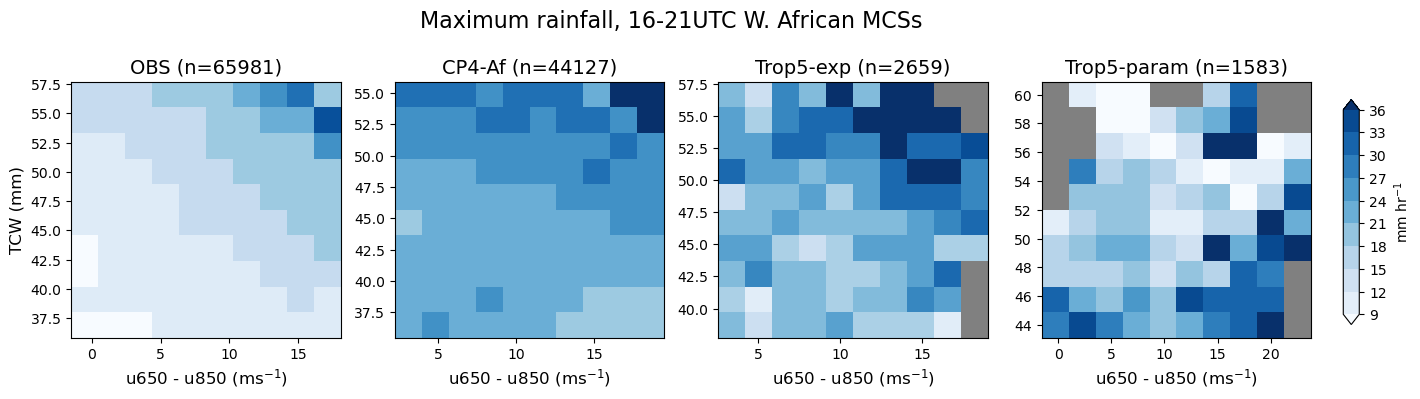

In [51]:
hierarchy_var_comparison(MCS_data_dict,"rain_max",cut_off=5,moist_var="tcw",shear_var="ushear650_850",grid_spec=10,min_pcle=0.05,max_pcle=0.95,full=False)#,save="1a")

In [16]:
def bin_hist_1d(MCS_data,MCS_var,bin_var,red_var,grid_spec=10,grid_spec2=None,cut_off=5,max_pcle=0.99,min_pcle=0.01):
    hist,pad,pad2,counts=bin_2d(MCS_data,moist_var=red_var,shear_var=bin_var,rain_var=MCS_var,t_var="tmin",
                                grid_spec=grid_spec,grid_spec2=grid_spec2,max_pcle=max_pcle,min_pcle=min_pcle)
    hist=hist.where(counts>=cut_off).rename({"q":"y","shear":"x"})
    red_counts=hist.count(dim="y")
    hist_red = hist.mean(dim="y").where(red_counts>1)
    std_err = hist.std(dim="y").where(red_counts>1)#/np.sqrt(red_counts.values)
    return hist_red, std_err, red_counts

def linear_fit(x,a0,a1):
    return a0 + x * a1

def multi_fits(ax,MCS_datas,models,MCS_var,bin_var,red_var,lobf=None,errs="fill",cut_off=5,grid_spec=10,grid_spec2=None,max_pcle=0.99,min_pcle=0.01):
    for i, MCS_data in enumerate(MCS_datas):
        try:
            plev=int(shear_var[-3:])
            try:
                plev=np.max(int(moist_var[-3:]),plev)
            except:
                pass
            MCS_data=MCS_data[MCS_data["psfc"]>plev]
            MCS_datas[i]=MCS_data
        except:
            pass
            
    for i in range(len(MCS_datas)):
        MCS_data=MCS_datas[i]
        y, y_err, counts = bin_1d(MCS_data,MCS_var,bin_var,red_var,grid_spec=grid_spec,grid_spec2=grid_spec2,cut_off=cut_off,max_pcle=max_pcle,min_pcle=min_pcle)
        y, y_err = y.dropna(dim="x"), y_err.dropna(dim="x")
        y=y.where(y_err)
        color=["goldenrod","steelblue","maroon","purple","green"][i]
        X = y["x"].values
        popt, pcov = curve_fit(linear_fit, X, y.values, sigma=y_err.values, absolute_sigma=True)
        #print(popt,np.sqrt(np.diag(pcov))) #pcov gives covariance matrix; take sqrt of diagonal elements for stddev of fit parameters
        out = linear_fit(X, *popt)

        # Do 2-sided t-test for significance of gradient as default method for applying lobf. Doing 2-sided means don't pre-impose physical relationship
        tval=abs(popt[1])/np.sqrt(np.diag(pcov)[1])
        p = stats.distributions.t.sf(2*tval, grid_spec-2)
        
        if lobf!=None:
            add_fit = lobf[i]
        elif stats.pearsonr(X,y.values)[1]<0.05:
            add_fit = p < 0.05
        else:
            #print(stats.pearsonr(X,y.values))
            add_fit = False
        #fit = sm.WLS(y.values, sm.add_constant(X), weights=y_err.values).fit()
        #out=fit.params[1]*X + fit.params[0]

        mk="o"
        if i == len(MCS_datas)-1 and len(MCS_datas)>4:
            mk="D"
        y.plot(ax=ax,marker=mk,color=color,zorder=(i+1)%2,label=models[i]+"; $\delta$={:.2f}$\pm${:.2f}".format(popt[1],np.sqrt(np.diag(pcov)[1])))#.format(fit.params[1],fit.bse[1]))
        if errs=="fill":
            ax.fill_between(y["x"].values,(y-y_err).values,(y+y_err).values,color=color,alpha=0.2,zorder=(i+1)%2)
        if errs=="bars":
            ax.errorbar(y["x"].values,y.values,yerr=y_err.values,color=color,alpha=0.8,zorder=(i+1)%2)
        if errs=="fit":
            ax.errorbar(y["x"].values,y.values,yerr=y_err.values,color=color,alpha=0.8,zorder=(i+1)%2)
            ax.fill_between(y["x"].values,out-np.sqrt(np.diag(pcov))[1]*out,out+np.sqrt(np.diag(pcov))[1]*out,color=color,alpha=0.2,zorder=(i+1)%2)
        if add_fit==True:
            ax.plot(X,out,color=color,ls="--")
        #r,p=stats.pearsonr(y.values,out)
    #ax.set_title("Grad.={:.2f}$\pm${:.2f}; r={:.2f} ({:.2f})".format(fit.params[1],fit.bse[1],r,p),fontsize=10,loc="center")
    ax.legend()
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_box_aspect(0.75)
    return ax

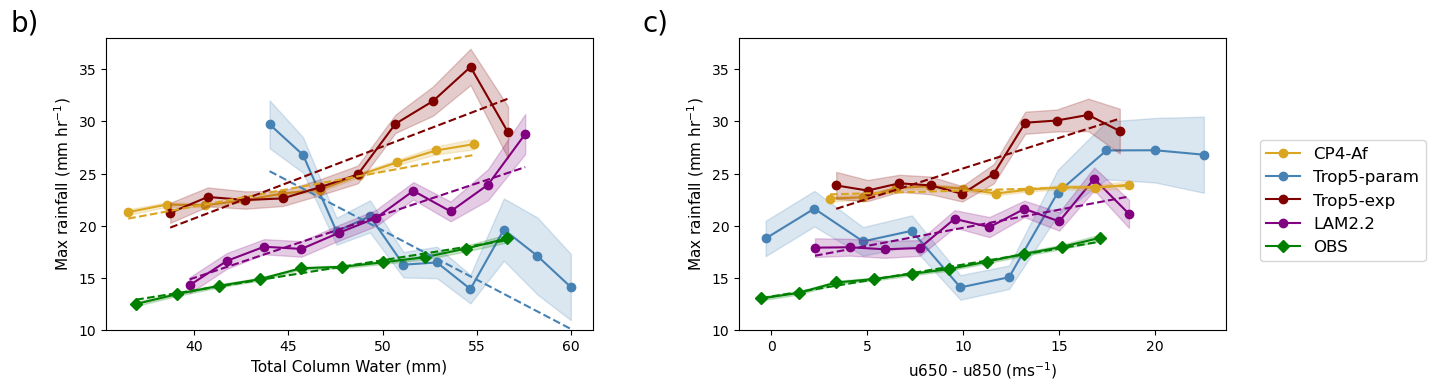

In [17]:
#16 - 21Z
from matplotlib.lines import Line2D
moist_var,shear_var="tcw","ushear650_850"
fig,ax=plt.subplots(1,2,figsize=(16,5),gridspec_kw={"wspace":0.3})
ax[0]=multi_fits(ax[0],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["OBS"]],["a","b","c","d","e"],"rain_max",
                 moist_var,shear_var,lobf=None,cut_off=5,grid_spec=10,min_pcle=0.05,max_pcle=0.95,errs="fill")
ax[0].set_xlabel("Total Column Water (mm)",fontsize=11)
ax[0].set_ylabel(r"Max rainfall (mm hr$^{-1}$)",fontsize=11)
ax[0].get_legend().remove()
ax[0].set_ylim([10,38])
ax[0].set_box_aspect(0.6)
#ax[0].set_ylim([0,12000])
ax[1]=multi_fits(ax[1],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["OBS"]],["a","b","c","d","e"],"rain_max",
                 shear_var,moist_var,lobf=None,cut_off=5,grid_spec=10,min_pcle=0.05,max_pcle=0.95,errs="fill")
ax[1].set_xlabel(r"u650 - u850 (ms$^{-1}$)",fontsize=11)
ax[1].set_ylabel(r"Max rainfall (mm hr$^{-1}$)",fontsize=11)
ax[1].get_legend().remove()
ax[1].set_ylim([10,38])
ax[1].set_box_aspect(0.6)
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='LAM2.2'),
                   Line2D([],[],color="green", marker="D", label='OBS')]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.2)
plt.figtext(0.14,0.8,"b)",fontsize=20)
plt.figtext(0.535,0.8,"c)",fontsize=20)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.03, 0.6))
#fig.savefig("fig1b.png",dpi=250,bbox_inches="tight",facecolor="white")

In [18]:
def fit_trend(MCS_data,MCS_var,bin_var="ushear650_850",red_var="tcw",grid_spec=10,cut_off=5,max_pcle=0.99,min_pcle=0.01,rval=False):
    try:
        MCS_data=MCS_data[MCS_data["psfc"]>850]
    except:
        pass
    """
        try:
            plev=int(shear_var[-3:])
            try:
                plev=np.max(int(moist_var[-3:]),plev)
            except:
                pass
            MCS_data=MCS_data[MCS_data["psfc"]>plev]
            MCS_datas[i]=MCS_data
        except:
            pass
    """
    y, y_err, counts = bin_1d(MCS_data,MCS_var,bin_var,red_var,grid_spec=grid_spec,cut_off=cut_off,max_pcle=max_pcle,min_pcle=min_pcle)
    y, y_err = y.dropna(dim="x"), y_err.dropna(dim="x")
    y=y.where(y_err)
    X = y["x"].values

    #fit = sm.WLS(y.values, sm.add_constant(X), weights=y_err.values).fit()
    popt, pcov = curve_fit(linear_fit, X, y.values, sigma=y_err.values, absolute_sigma=True)
    if rval:
        print(stats.pearsonr(y.x,y))
    #out = linear_fit(X, *popt)
    # returns 1D histogram, gradient, intercept

    
    tval=abs(popt[1])/np.sqrt(np.diag(pcov)[1])
    t_ref=stats.distributions.t.ppf(1.0-0.5*0.05, grid_spec-2)
    p = 2*stats.distributions.t.sf(tval, grid_spec-2)
    if tval < t_ref:
        print("Fit gradient not p<0.05 significant %.3f < %.3f , p = %.3f" % (tval, t_ref,p))
    return(y,popt,np.diag(pcov))

In [19]:
shear,q="ushear650_850","tcw"
#shear,q="tcw","ushear650_850"
print("Ratio of model 1D trend gradient to OBS: max rain response to "+shear)
for sim in list(MCS_data_dict.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dict[sim]
    bin_rain,rain_popt,rain_pcov=fit_trend(MCS_data,"rain_max",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q,rval=True,cut_off=5,grid_spec=10)
    bin_obs,obs_popt,obs_pcov=fit_trend(MCS_data_dict["OBS"],"rain_max",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    # get ratio of gradients and its error - std error of gradient is stddev of gradient, sqrt of covariance matrix element
    print("\delta / \delta_{OBS} = %.3f +/- %.3f" %(rain_popt[1]/obs_popt[1], (rain_popt[1]/obs_popt[1])*np.sqrt((np.sqrt(rain_pcov[1])/rain_popt[1])**2 + (np.sqrt(obs_pcov[1])/obs_popt[1])**2)))

    tval=abs(rain_popt[1] - obs_popt[1])/np.sqrt(rain_pcov[1])
    p = stats.distributions.t.sf(tval, len(bin_rain)-2) * 2
    print("t test for difference between model and OBS gradient gives p = %.3f"%p)

Ratio of model 1D trend gradient to OBS: max rain response to ushear650_850
Channel_GAL9
PearsonRResult(statistic=0.6308614230422123, pvalue=0.05049258190161449)
Fit gradient not p<0.05 significant 1.238 < 2.306 , p = 0.251
\delta / \delta_{OBS} = 0.385 +/- 0.312
t test for difference between model and OBS gradient gives p = 0.084
Channel_RAL3
PearsonRResult(statistic=0.8515748983785678, pvalue=0.0017679952201020404)
\delta / \delta_{OBS} = 1.906 +/- 0.288
t test for difference between model and OBS gradient gives p = 0.012
CP4
PearsonRResult(statistic=0.7040057289571137, pvalue=0.023063053065349833)
\delta / \delta_{OBS} = 0.169 +/- 0.052
t test for difference between model and OBS gradient gives p = 0.000
Lam
PearsonRResult(statistic=0.8294242270869221, pvalue=0.0029982352361210595)
\delta / \delta_{OBS} = 1.129 +/- 0.196
t test for difference between model and OBS gradient gives p = 0.518


FIGURE 2 - entrainment rate variability

In [20]:
print("Ratio of CP4 mean anvil area to OBS mean")
MCS_data_dict["CP4"]["area"].mean()/MCS_data_dict["OBS"]["area"].mean()

Ratio of CP4 mean anvil area to OBS mean


0.5785829680330701

In [21]:
shear,q="ushear650_850","tcw"
print("Ratio of model 1D trend gradient to OBS: anvil area response to "+shear)
for sim in list(MCS_data_dictw.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dict[sim]
    bin_rain,mod_popt,mod_pcov=fit_trend(MCS_data,"area",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    bin_obs,obs_popt,obs_pcov=fit_trend(MCS_data_dict["OBS"],"area",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    print("\delta / \delta_{OBS} = %.3f +/- %.3f" %(mod_popt[1]/obs_popt[1], (mod_popt[1]/obs_popt[1])*np.sqrt((np.sqrt(mod_pcov[1])/mod_popt[1])**2 + (np.sqrt(obs_pcov[1])/obs_popt[1])**2)))

Ratio of model 1D trend gradient to OBS: anvil area response to ushear650_850
Channel_GAL9
\delta / \delta_{OBS} = 0.731 +/- 0.097
Channel_RAL3
\delta / \delta_{OBS} = 1.141 +/- 0.121
CP4
\delta / \delta_{OBS} = 0.387 +/- 0.016
Lam
\delta / \delta_{OBS} = 1.133 +/- 0.129


In [22]:
shear,q="ushear650_850","tcw"
print("Ratio of model 1D trend gradient to OBS: min BT response to "+shear)
for sim in list(MCS_data_dict.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dict[sim]
    bin_rain,rain_popt,rain_pcov=fit_trend(MCS_data,"tmin",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q,rval=True)
    bin_obs,obs_popt,obs_pcov=fit_trend(MCS_data_dict["OBS"],"tmin",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    # get ratio of gradients and its error - std error of gradient is stddev of gradient, sqrt of covariance matrix element
    print("\delta / \delta_{OBS} = %.3f +/- %.3f" %(rain_popt[1]/obs_popt[1], (rain_popt[1]/obs_popt[1])*np.sqrt((np.sqrt(rain_pcov[1])/rain_popt[1])**2 + (np.sqrt(obs_pcov[1])/obs_popt[1])**2)))

    tval=abs(rain_popt[1] - obs_popt[1])/np.sqrt(rain_pcov[1])
    p = stats.distributions.t.sf(tval, len(bin_rain)-2) * 2
    print("t test for difference between model and OBS gradient gives p = %.3f"%p)

Ratio of model 1D trend gradient to OBS: min BT response to ushear650_850
Channel_GAL9
PearsonRResult(statistic=-0.8281525501063256, pvalue=0.003083627640632183)
\delta / \delta_{OBS} = 0.332 +/- 0.062
t test for difference between model and OBS gradient gives p = 0.000
Channel_RAL3
PearsonRResult(statistic=-0.9728737797573384, pvalue=2.2925961145749613e-06)
\delta / \delta_{OBS} = 1.036 +/- 0.088
t test for difference between model and OBS gradient gives p = 0.692
CP4
PearsonRResult(statistic=-0.952216831321216, pvalue=2.1525589949709115e-05)
\delta / \delta_{OBS} = 0.246 +/- 0.017
t test for difference between model and OBS gradient gives p = 0.000
Lam
PearsonRResult(statistic=-0.9296043574461035, pvalue=9.86264679121325e-05)
\delta / \delta_{OBS} = 0.988 +/- 0.067
t test for difference between model and OBS gradient gives p = 0.859


In [23]:
for sim in list(MCS_data_dictw.keys())[:-1]:
    MCS_data_dictw[sim]=MCS_data_dictw[sim][~np.isnan(MCS_data_dictw[sim]["tlnb-6"])] 
    # CP4 has a few entries with extremely small CAPE-6 values; ensuring lnb exists removes these.
    MCS_data_dictw[sim]["btdiff"]=MCS_data_dictw[sim]["tmean"]-(MCS_data_dictw[sim]["tlnb-6"]-273.15)
    MCS_data_dictw[sim]["w_eff"]=(MCS_data_dictw[sim]["max_w500"] / MCS_data_dictw[sim]["rootCAPE"]).replace(np.inf,np.NaN)

In [24]:
def entrainment_plot(MCS_datas,models,region="Wafrica",moist_var="tcw",shear_var="ushear650_850",lnb="tlnb-6",cut_off=5,grid_spec=10,
                     max_pcle=0.99,min_pcle=0.01,com_scale=True,save=False):
    if type(MCS_datas) != list:
        MCS_datas,models=[MCS_datas],[models]
    for i, MCS_data in enumerate(MCS_datas):
        try:
            plev=int(shear_var[-3:])
            try:
                plev=np.max(int(moist_var[-3:]),plev)
            except:
                pass
            MCS_data=MCS_data[MCS_data["psfc"]>plev]
        except:
            pass

        #MCS_data["btdiff"]=MCS_data["tmean"]-(MCS_data[lnb]-273.15)
        #MCS_data["w_eff"]=(MCS_data["max_w500"] / MCS_data["CAPE-6"]**0.5).replace(np.inf,np.NaN)
        #MCS_data["w_eff"]=MCS_data["w_eff"][MCS_data["w_eff"]<2]
        MCS_datas[i]=MCS_data

    xlab=shear_var
    if "shear" in shear_var:
        xlab="u%s - u%s (m s$^{-1}$)"%(shear_var[6:9],shear_var[-3:])
    ylab,tvar=moist_var,moist_var
    if moist_var[0]=="q":
        ylab="q%s (g kg$^{-1}$)" % moist_var[-3:]
        tvar="q"
    elif moist_var=="tcw":
        ylab="TCW (mm)"
        tvar="TCW"

    var1="w_eff"
    var_str1,unit1=r"w500$_{\rm max}$ / $\sqrt{\rm CAPE_{env}}$",""
    var2="btdiff"
    var_str2,unit2=r"T$_{\rm anvil}$ - LNB$_{\rm env}$",r" ($^{\circ}$C)"
        
    fig,axes=plt.subplots(3,len(MCS_datas),figsize=(6*len(MCS_datas),13),gridspec_kw={"hspace":0.08})
    vmin1,vmax1=1e9,-1e9
    vmin2,vmax2=1e9,-1e9
    v1_hists,v2_hists=[],[]
    for i, MCS_data in enumerate(MCS_datas):
        hist,tvals,areas,counts=bin_2d(MCS_data,moist_var=moist_var,shear_var=shear_var,rain_var=var1,grid_spec=grid_spec,max_pcle=max_pcle,min_pcle=min_pcle)
        #diffs_plot(hist,axes.flatten()[i],cmaps[:2])
        hist=hist.where(counts>=cut_off)
        v1_hists.append(hist)
        if hist.quantile(0.99)>vmax1:
            vmax1=float(hist.quantile(0.99))
        if hist.quantile(0.01)<vmin1:
            vmin1=float(hist.quantile(0.01))

        hist,tvals,areas,counts=bin_2d(MCS_data,moist_var=moist_var,shear_var=shear_var,rain_var=var2,grid_spec=grid_spec,max_pcle=max_pcle,min_pcle=min_pcle)
        #diffs_plot(hist,axes.flatten()[i],cmaps[:2])
        hist=hist.where(counts>=cut_off)
        v2_hists.append(hist)
        if hist.quantile(0.99)>vmax2:
            vmax2=float(hist.quantile(0.99))
        if hist.quantile(0.01)<vmin2:
            vmin2=float(hist.quantile(0.01))

    for i, MCS_data in enumerate(MCS_datas):
        if com_scale==False:
            vmax1=float(v1_hists[i].quantile(0.99))
            vmin1=float(v1_hists[i].quantile(0.01))
        #diffs_plot(hists[i],axes.flatten()[i],cmaps,vmin,vmax)
        ax1=axes.flatten()[len(MCS_datas)+i]
        v1_hists[i].plot(ax=axes.flatten()[i],cmap="pink",vmin=vmin1,vmax=vmax1,cbar_kwargs={"label":var_str1+unit1})
        temp=MCS_data[var1].dropna(axis=0)
        axes.flatten()[i].set_title(r"%s $w_{\rm eff}$ ($n=\bf %s$)"%(models[i],len(temp)),fontsize=14)
        
        y, y_err, counts = bin_1d(MCS_datas[i],var1,shear_var,moist_var,grid_spec=grid_spec,cut_off=cut_off,max_pcle=max_pcle,min_pcle=min_pcle)
        y, y_err = y.dropna(dim="x"), y_err.dropna(dim="x")
        X = y["x"].values
        popt, pcov = curve_fit(linear_fit, X, y.values, sigma=y_err.values, absolute_sigma=True)
        out = linear_fit(X, *popt)
        #y = y.where(y_err)
        y.plot(ax=ax1,marker="o",color="sienna")
        ax1.fill_between(y["x"].values,(y-y_err).values,(y+y_err).values,color="goldenrod",alpha=0.2)
        tval=popt[1]/np.sqrt(np.diag(pcov)[1])
        p = stats.distributions.t.sf(tval, grid_spec-2)
        if p<0.05 and stats.pearsonr(X,y.values)[1]<0.05:
            ax1.plot(X,out,color="sienna",ls="--")

        ax2=ax1.twinx()
        if i<2:
            ax2.set_ylim([1,8])
        elif i==2:
            ax2.set_ylim([4,11])
        elif i==3:
            ax2.set_ylim([-4,3])
            #ax2.axhline(0,alpha=0.4,color="k")
        y, y_err, counts = bin_1d(MCS_datas[i],var2,shear_var,moist_var,grid_spec=grid_spec,cut_off=cut_off,max_pcle=max_pcle,min_pcle=min_pcle)
        y, y_err = y.dropna(dim="x"), y_err.dropna(dim="x")
        y = y.where(y_err)
        y.plot(ax=ax2,marker="o",color="mediumseagreen")
        ax2.fill_between(y["x"].values,(y-y_err).values,(y+y_err).values,color="yellowgreen",alpha=0.2)
        #if i==0 or i==1:
        X = y["x"].values
        popt, pcov = curve_fit(linear_fit, X, y.values, sigma=y_err.values, absolute_sigma=True)
        out = linear_fit(X, *popt)
        tval=abs(popt[1])/np.sqrt(np.diag(pcov)[1])
        p = stats.distributions.t.sf(2*tval, grid_spec-2)
        if p<0.05 and stats.pearsonr(X,y.values)[1]<0.05:
            ax2.plot(X,out,color="mediumseagreen",ls="--")

        if i==0:
            legend_elements = [Line2D([],[],color="sienna", marker="o", label=r"$\rm w_{eff}$"),Line2D([],[],color="mediumseagreen", marker="o", label=r"$\rm BT_{diff}$")]
            ax1.legend(handles=legend_elements)
        #ax2.set_ylabel(var_str2+unit2,fontsize=12)
        #if i<2:
        #    ax2.set_yticklabels([])
        ax1.set_title(models[i],fontsize=14)
        
        vmax2=max(abs(vmin2),vmax2)
        v2_hists[i].plot(ax=axes.flatten()[2*len(MCS_datas)+i],cmap="PiYG",vmin=-vmax2,vmax=vmax2,cbar_kwargs={"label":var_str2+unit2})
        temp=MCS_data[var2].dropna(axis=0)
        axes.flatten()[2*len(MCS_datas)+i].set_title(r"%s BT$_{\rm diff}$ ($n=\bf %s$)"%(models[i],len(temp)),fontsize=14)

    for i in range(len(MCS_datas)):
        axes[0,i].set_xlabel(xlab,fontsize=12)
        axes[0,i].set_box_aspect(0.95)
        axes[0,i].set_facecolor("grey")
        axes[0,i].set_ylabel("")
        axes[1,i].set_box_aspect(0.45)
        axes[1,i].set_xlabel(xlab,fontsize=12)
        axes[1,i].set_ylabel("")
        axes[1,i].set_ylim([0.02,0.42])
        #if i>0:
        #    axes[1,i].set_yticklabels([])
        axes[2,i].set_xlabel(xlab,fontsize=12)
        axes[2,i].set_box_aspect(0.95)
        axes[2,i].set_facecolor("grey")
        axes[2,i].set_ylabel("")
        #axes[i,0].set_ylabel(ylab,fontsize=12)
        #axes[1,i].set_ylabel(r"w$_{\rm eff}$"+unit1,fontsize=12)
    ax2.set_ylabel(r"BT$_{\rm diff}$"+unit2,fontsize=12)
    axes[0,0].set_ylabel(ylab,fontsize=12)
    axes[1,0].set_ylabel(r"w$_{\rm eff}$"+unit1,fontsize=12)
    axes[2,0].set_ylabel(ylab,fontsize=12)
    #for ax in axes[:,i]
    #    ax.set_anchor('W')

    
    plt.figtext(0.085,0.89,"a)",fontsize=24)
    plt.figtext(0.085,0.57,"b)",fontsize=24)
    plt.figtext(0.085,0.355,"c)",fontsize=24)
    fig.suptitle("Entrainment-dilution measures, 18+21UTC W. African MCSs",fontsize=18,y=0.95)
    if save==True:
        fig.savefig("fig2.png",dpi=200,bbox_inches="tight",facecolor="white")


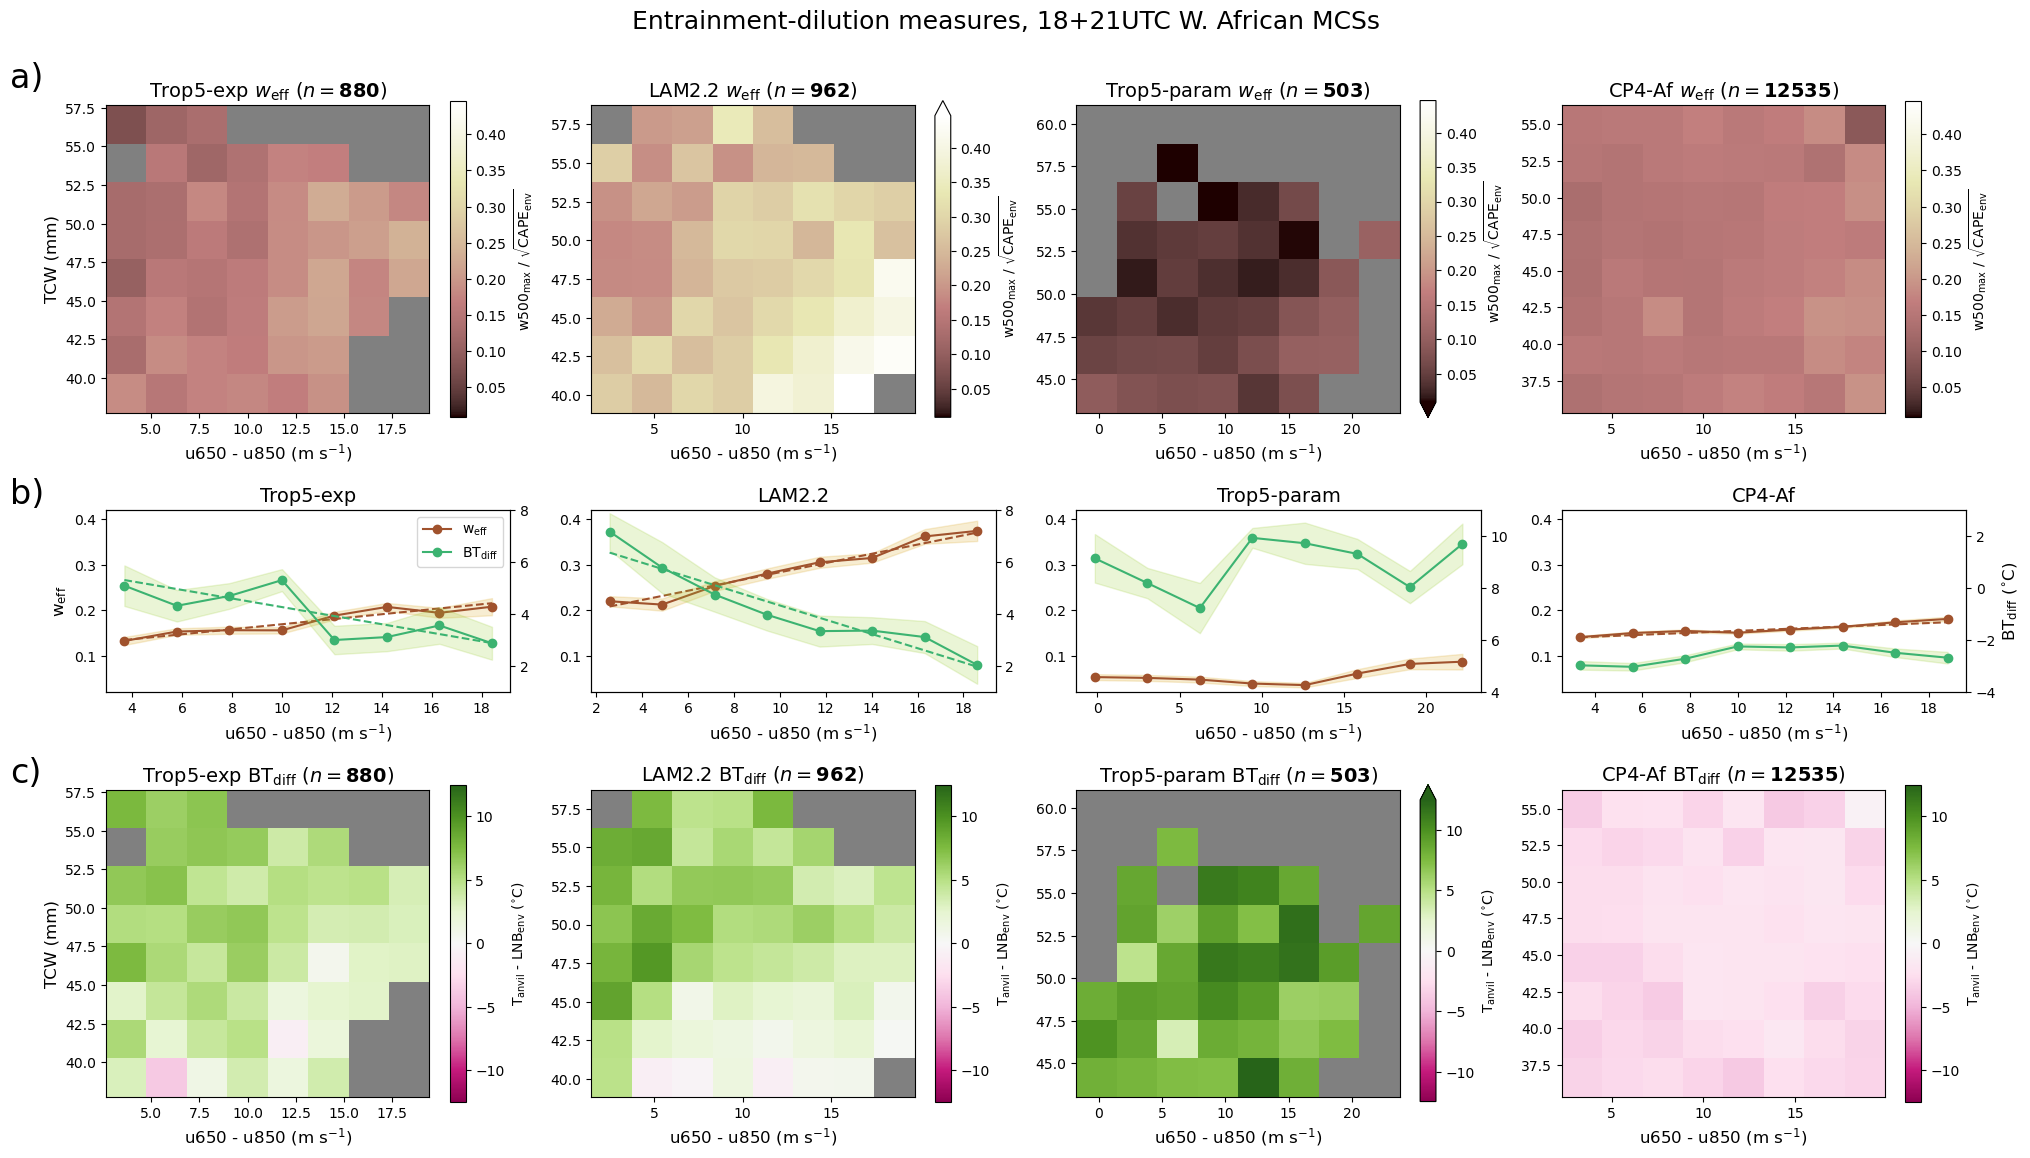

In [25]:
entrainment_plot([MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["CP4"]],["Trop5-exp","LAM2.2","Trop5-param","CP4-Af"],com_scale=True,
                 cut_off=5,grid_spec=8,max_pcle=0.95,min_pcle=0.05,moist_var="tcw")#,save=True)

In [26]:
#shear,q="tcw","ushear650_850"
shear,q="ushear650_850","tcw"
print("1D bin correlations")
for sim in list(MCS_data_dictw.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dictw[sim]
    MCS_data2=MCS_data_dict[sim]
    """
    bin_rain,rain_popt,rain_pcov=fit_trend(MCS_data,"btdiff",max_pcle=0.95,min_pcle=0.05)
    bin_core,core_popt,core_pcov=fit_trend(MCS_data,"area_w500_p99_core",max_pcle=0.95,min_pcle=0.05)
    print("BTdiff vs core area: ", stats.pearsonr(bin_rain.values,bin_core.values))
    bin_rain,rain_popt,rain_pcov=fit_trend(MCS_data,"w_eff",max_pcle=0.95,min_pcle=0.05)
    bin_core,core_popt,core_pcov=fit_trend(MCS_data,"area_w500_p99_core",max_pcle=0.95,min_pcle=0.05)
    print("weff vs core area: ", stats.pearsonr(bin_rain.values,bin_core.values))
    bin_rain,rain_popt,rain_pcov=fit_trend(MCS_data,"w_eff",max_pcle=0.95,min_pcle=0.05)
    bin_core,core_popt,core_pcov=fit_trend(MCS_data,"btdiff",max_pcle=0.95,min_pcle=0.05)
    print("BTdiff vs weff: ", stats.pearsonr(bin_rain.values,bin_core.values))
    """
    gs=10
    bin_rain=fit_trend(MCS_data,"w_eff",max_pcle=0.95,min_pcle=0.05,grid_spec=gs,bin_var=shear,red_var=q)
    bin_cores=fit_trend(MCS_data2,"rain_max",max_pcle=0.95,min_pcle=0.05,grid_spec=gs,bin_var=shear,red_var=q)
    print("weff vs rain max: ", stats.pearsonr(bin_rain[0].values,bin_cores[0].values))
    bin_rain=fit_trend(MCS_data,"btdiff",max_pcle=0.95,min_pcle=0.05,grid_spec=gs,bin_var=shear,red_var=q)
    bin_cores=fit_trend(MCS_data2,"rain_max",max_pcle=0.95,min_pcle=0.05,grid_spec=gs,bin_var=shear,red_var=q)
    print("BTdiff vs rain max: ", stats.pearsonr(bin_rain[0].values,bin_cores[0].values))

1D bin correlations
Channel_GAL9
Fit gradient not p<0.05 significant 0.782 < 2.306 , p = 0.457
Fit gradient not p<0.05 significant 1.238 < 2.306 , p = 0.251
weff vs rain max:  PearsonRResult(statistic=0.8994498531434028, pvalue=0.00039547543125951606)
Fit gradient not p<0.05 significant 1.227 < 2.306 , p = 0.255
Fit gradient not p<0.05 significant 1.238 < 2.306 , p = 0.251
BTdiff vs rain max:  PearsonRResult(statistic=-0.21118787210165513, pvalue=0.5580851768897952)
Channel_RAL3
weff vs rain max:  PearsonRResult(statistic=0.9139919199857017, pvalue=0.00021557160842109195)
BTdiff vs rain max:  PearsonRResult(statistic=-0.7630512679225206, pvalue=0.010243725606324668)
CP4
weff vs rain max:  PearsonRResult(statistic=0.72866054762215, pvalue=0.01683265106600973)
BTdiff vs rain max:  PearsonRResult(statistic=0.37286588839786766, pvalue=0.28860778072957327)
Lam
weff vs rain max:  PearsonRResult(statistic=0.8988611021228287, pvalue=0.00040452278055563487)
BTdiff vs rain max:  PearsonRResult(s

In [28]:
shear,q="ushear650_850","tcw"
var="btdiff"
print("Ratio of model 1D trend gradient to CP4: {} response to ".format(var)+shear)
for sim in list(MCS_data_dictw.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dictw[sim]
    bin_mod,mod_popt,mod_pcov=fit_trend(MCS_data,var,max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    bin_obs,obs_popt,obs_pcov=fit_trend(MCS_data_dictw["CP4"],var,max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    print("\delta / \delta_{CP4} = %.3f +/- %.3f" %(mod_popt[1]/obs_popt[1], (mod_popt[1]/obs_popt[1])*np.sqrt((np.sqrt(mod_pcov[1])/mod_popt[1])**2 + (np.sqrt(obs_pcov[1])/obs_popt[1])**2)))

Ratio of model 1D trend gradient to CP4: btdiff response to ushear650_850
Channel_GAL9
Fit gradient not p<0.05 significant 1.227 < 2.306 , p = 0.255
\delta / \delta_{CP4} = 0.828 +/- 0.701
Channel_RAL3
\delta / \delta_{CP4} = -2.811 +/- -1.148
CP4
\delta / \delta_{CP4} = 1.000 +/- 0.326
Lam
\delta / \delta_{CP4} = -4.848 +/- -1.443


In [29]:
shear,q="ushear650_850","tcw"
print("Ratio of model 1D trend gradient to OBS: anvil BT response to "+shear)
for sim in list(MCS_data_dictw.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dict[sim]
    bin_mod,mod_popt,mod_pcov=fit_trend(MCS_data,"tmean",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    bin_obs,obs_popt,obs_pcov=fit_trend(MCS_data_dict["OBS"],"tmean",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    print("\delta / \delta_{OBS} = %.3f +/- %.3f" %(mod_popt[1]/obs_popt[1], (mod_popt[1]/obs_popt[1])*np.sqrt((np.sqrt(mod_pcov[1])/mod_popt[1])**2 + (np.sqrt(obs_pcov[1])/obs_popt[1])**2)))

Ratio of model 1D trend gradient to OBS: anvil BT response to ushear650_850
Channel_GAL9
\delta / \delta_{OBS} = 0.260 +/- 0.044
Channel_RAL3
\delta / \delta_{OBS} = 0.894 +/- 0.083
CP4
\delta / \delta_{OBS} = 0.322 +/- 0.017
Lam
\delta / \delta_{OBS} = 0.883 +/- 0.062


FIGURE 3 - core area variation with shear

In [30]:
def diffs_plot(da,ax,cmaps,vmin,vmax):
    temp=da.values.ravel()
    temp=temp[~np.isnan(temp)]
    if len(np.unique(np.sign(temp)))==1:
        if abs(vmin)>vmax:
            da.plot(ax=ax,cmap=cmaps[0],vmin=vmin,cbar_kwargs={"label":lab_str},robust=True)
        else:
            da.plot(ax=ax,cmap=cmaps[0],vmax=vmax,cbar_kwargs={"label":var_str+unit},robust=True)                
    else:
        try:
            #norm = TwoSlopeNorm(vmin=da.quantile(.05), vcenter=0, vmax=da.max())
            norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
            da.plot(ax=ax,cmap=cmaps[1],norm=norm,cbar_kwargs={"label":var_str+unit})  
        except:
            da.plot(ax=ax,cmap=cmaps[1],vmax=vmax,robust=True,cbar_kwargs={"label":var_str+unit}) 

In [31]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [32]:
def model_histograms(MCS_datas,models,plot_var,region="Wafrica",moist_var="tcw",shear_var="ushear650_850",cut_off=5,grid_spec=10,
                     com_scale=True,save=False,max_pcle=0.99,min_pcle=0.01,cmap=None):
    if type(MCS_datas) != list:
        MCS_datas,models=[MCS_datas],[models]
    for i, MCS_data in enumerate(MCS_datas):
        try:
            plev=int(shear_var[-3:])
            try:
                plev=np.max(int(moist_var[-3:]),plev)
            except:
                pass
            MCS_data=MCS_data[MCS_data["psfc"]>plev]
        except:
            pass

        try:
            MCS_data["btdiff"]=MCS_data["tmean"]-(MCS_data[lnb]-273.15)
        except:
            pass
        try:
            MCS_data["theta_diff"]= MCS_data["theta_e_mcs_200_nat"] - MCS_data[theta_sfc]
        except:
            pass
        #MCS_data=MCS_data[MCS_data["hour"]==18]
        MCS_datas[i]=MCS_data
        

    xlab=shear_var
    if "shear" in shear_var:
        xlab="u%s - u%s (ms$^{-1}$)"%(shear_var[6:9],shear_var[-3:])
    ylab,tvar=moist_var,moist_var
    if moist_var[0]=="q":
        ylab="q%s (g kg$^{-1}$)" % moist_var[-3:]
        tvar="q"
    elif moist_var=="tcw":
        ylab="TCW (mm)"
        tvar="TCW"
    elif moist_var=="rootCAPE":
        ylab=r"$\sqrt{\rm CAPE_{env}}$"
        tvar=ylab
    elif moist_var=="w_eff":
        ylab=r"w$_{\rm eff}$"
        tvar=ylab

    var_str,unit,min=plot_var,"",0
    if cmap==None:
        cmap="viridis"
    fig,axes=plt.subplots(1,len(MCS_datas),figsize=(6*len(MCS_datas),4.5),gridspec_kw={"hspace":0.15})
    if plot_var=="theta_e_core_buoy":
        cmap = truncate_colormap(plt.get_cmap('PRGn'), 0.5, 1)
        var_str,unit=r"$\theta_e^{\rm core} - \theta_e^{\rm * env}$"," (K)"
        min=0 # can actually be negative, but this forces all colorbars for positive values fully positive when using cscale=int
    elif "_core" in plot_var:
        cmap="Purples"
        var_str,unit="Core area (w500>%s)"%plot_var[10:-5].replace("ms","m/s"),r" (km$^{2}$)"
    elif plot_var=="max_w500":
        cmap="Greens"
        var_str,unit=r"w500$_{\rm max}$",r" (ms$^{-1}$)"
    elif "rain" in plot_var:
        cmap="Blues"
        var_str,unit="{} rainfall".format(plot_var[5:].capitalize()),r" (mm hr$^{-1}$)"
    elif "count" in plot_var:
        cmap="viridis"
        var_str,unit="Number of storms",""
        
    vmin,vmax=1e9,-1e9
    hists=[]    
    for i, MCS_data in enumerate(MCS_datas):
        #diffs_plot(hist,axes.flatten()[i],cmaps[:2])
        if "count" in plot_var:
            if len(plot_var) > 5:
                MCS_data=MCS_data[MCS_data.hour==int(plot_var[-2:])]
            hist,tvals,areas,counts=bin_2d(MCS_data,moist_var=moist_var,shear_var=shear_var,grid_spec=grid_spec,max_pcle=max_pcle,min_pcle=min_pcle)
            hist=counts.where(counts>=cut_off)
        else:
            hist,tvals,areas,counts=bin_2d(MCS_data,moist_var=moist_var,shear_var=shear_var,rain_var=plot_var,grid_spec=grid_spec,max_pcle=max_pcle,min_pcle=min_pcle)
            hist=hist.where(counts>=cut_off)
        hists.append(hist)
        if models[i].lower()=="trop5-param" and "_core" in plot_var:
            continue
        else:
            if hist.quantile(0.99)>vmax:
                vmax=float(hist.quantile(0.99))
            if hist.quantile(0.01)<vmin:
                vmin=float(hist.quantile(0.01))

    for i, MCS_data in enumerate(MCS_datas):
        
        if com_scale==False:
            vmax=float(hists[i].quantile(0.99))
            vmin=float(hists[i].quantile(0.01))
        elif type(com_scale)==tuple:
            vmin=com_scale[0]
            vmax=com_scale[1]
        elif type(com_scale)==int:
            med=np.nanmean(hists[i].values.flatten())
            vmin=med-com_scale/2
            vmax=med+com_scale/2
            if vmin < min:
                vmin=0
                vmax=com_scale
        #if plot_var=="theta_e_core_buoy":
        #    vmin=-vmax
        #diffs_plot(hists[i],axes.flatten()[i],cmaps,vmin,vmax)
        
        if models[i].lower()!="trop5-param":
            hists[i].plot(ax=axes[i],cmap=cmap,cbar_kwargs={"label":var_str+unit},robust=True,vmin=vmin,vmax=vmax)
        else:
            if plot_var=="theta_e_core_buoy":
                hists[i].plot(ax=axes[i],cmap="PRGn",cbar_kwargs={"label":var_str+unit},robust=True,vmin=-com_scale,vmax=com_scale)
            elif "_core" in plot_var:
                #med=300#float(hists[i].median())
                #diff=vmax-vmin
                hists[i].plot(ax=axes[i],cmap=cmap,cbar_kwargs={"label":var_str+unit},robust=True,vmin=vmin,vmax=vmax)#,vmin=med-diff/2,vmax=med+diff/2)
           
            else:
                hists[i].plot(ax=axes[i],cmap=cmap,cbar_kwargs={"label":var_str+unit},robust=True,vmin=vmin,vmax=vmax)
        
        if "count" in plot_var:
            if len(plot_var) > 5:
                MCS_data=MCS_data[MCS_data.hour==int(plot_var[-2:])]
            temp=MCS_data
        else:
            temp=MCS_data[["hour",plot_var]].dropna(axis=0)
        axes[i].set_title(r"{} ($n=\bf %s$)".format(models[i])%len(temp),fontsize=14)
        
    for i, ax in enumerate(axes):
        ax.set_xlabel(xlab,fontsize=12)
        ax.set_box_aspect(0.95)
        ax.set_facecolor("grey")
        ax.set_ylabel(ylab,fontsize=12)
        #else:
        #    ax.set_box_aspect(0.5)
        #if i==3:
            #ax.set_ylim([125,275])
            #ax.set_yticks([150,200,250])
        #if i>3:
        #    ax.set_ylim([50,200])
        #    ax.set_yticks([50,100,150,200])
            
    #axes.flatten()[0].set_ylabel(ylab,fontsize=12)
    #axes.flatten()[len(MCS_datas)].set_ylabel(var_str+unit)
    fig.suptitle("{} scalings, 18+21UTC W. African MCSs".format(var_str),fontsize=18,y=1)
    if "ushear" not in shear_var:
        return fig, axes
    #fig.suptitle(r"18UTC MCS ($\bf n=%s$)"% len(MCS_data["bt_diff"].dropna()) + " {}:\n {}, {} {}".format(tit_str,region2.capitalize(),phys,model2),fontsize="14")
    if save:
        plt.figtext(0.09,0.93,save[-1]+")",fontsize=28)
        fig.savefig("fig{}.png".format(save),dpi=200,bbox_inches="tight",facecolor="white")

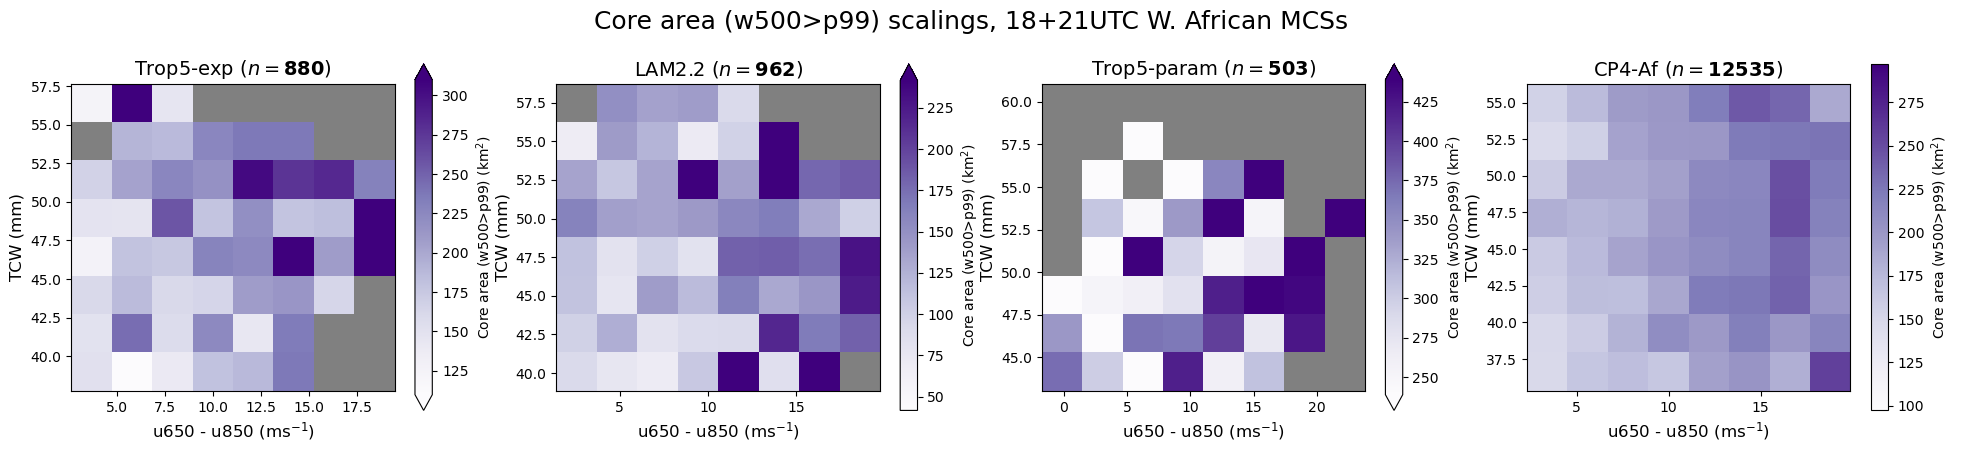

In [33]:
model_histograms([MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["CP4"]],
                 ["Trop5-exp","LAM2.2","Trop5-param","CP4-Af"],"area_w500_p99_core",cut_off=5,com_scale=200,moist_var="tcw",grid_spec=8,max_pcle=0.95,min_pcle=0.05)#,save="3a")

Text(0.545, 0.8, 'c)')

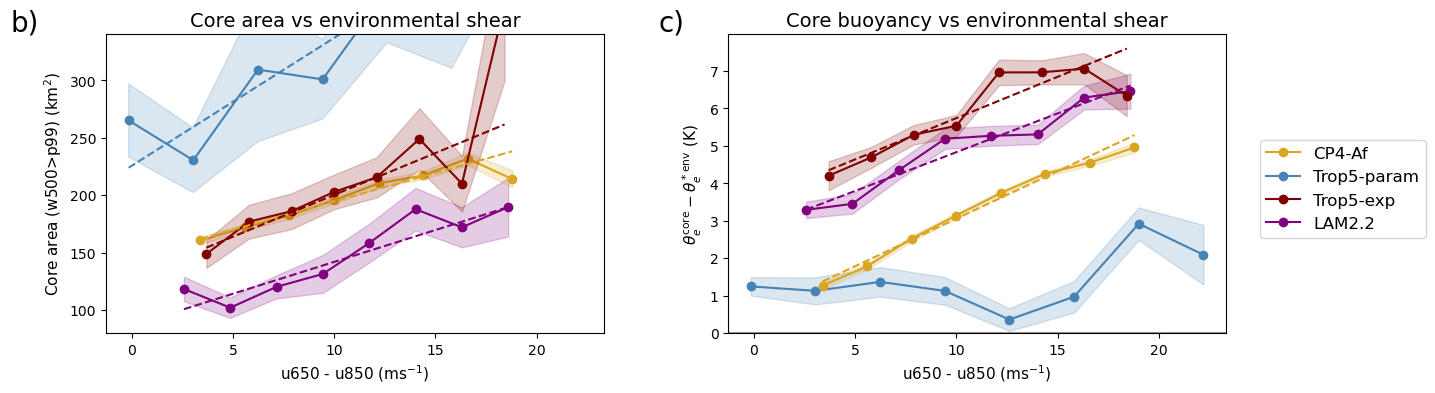

In [34]:
moist_var,shear_var="tcw","ushear650_850"
fig,ax=plt.subplots(1,2,figsize=(16,5),gridspec_kw={"wspace":0.25})
ax[0]=multi_fits(ax[0],[MCS_data_dictw["CP4"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"]],["a","b","c","d"],"area_w500_p99_core",
                 shear_var,moist_var,lobf=None,cut_off=5,grid_spec=8,max_pcle=0.95,min_pcle=0.05,errs="fill")
ax[0].set_box_aspect(0.6)
ax[0].set_xlabel(r"u650 - u850 (ms$^{-1}$)",fontsize=11)
ax[0].set_ylabel(r"Core area (w500>p99) (km$^2$)",fontsize=11)
ax[0].get_legend().remove()
ax[0].set_ylim([80,340])
ax[0].set_title("Core area vs environmental shear",fontsize=14)
#ax[0].set_ylim([0,12000])
ax[1].axhline(0,alpha=0.4,color="k")
ax[1]=multi_fits(ax[1],[MCS_data_dictw["CP4"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"]],["a","b","c","d"],"theta_e_core_buoy",shear_var,moist_var,
                 lobf=None,cut_off=5,grid_spec=8,max_pcle=0.95,min_pcle=0.05,errs="fill")
ax[1].set_ylim([0,None])
ax[1].set_box_aspect(0.6)
ax[1].set_xlabel(r"u650 - u850 (ms$^{-1}$)",fontsize=11)
ax[1].set_ylabel(r"$\theta_e^{\rm core} - \theta_e^{\rm * env}$ (K)",fontsize=11)
ax[1].set_title("Core buoyancy vs environmental shear",fontsize=14)
ax[1].get_legend().remove()
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='LAM2.2')]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.2)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.03, 0.6))
plt.figtext(0.14,0.8,"b)",fontsize=20)
plt.figtext(0.545,0.8,"c)",fontsize=20)
#fig.savefig("fig3b.png",dpi=200,bbox_inches="tight",facecolor="white")

In [35]:
shear,q="ushear650_850","tcw"
var="area_w500_p99_core"
print("Ratio of model 1D trend gradient to CP4: {} response to ".format(var.replace("_"," "))+shear)
for sim in list(MCS_data_dictw.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dictw[sim]
    bin_rain,mod_popt,mod_pcov=fit_trend(MCS_data,var,max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    bin_obs,obs_popt,obs_pcov=fit_trend(MCS_data_dictw["CP4"],var,max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    print("\delta / \delta_{CP4} = %.3f +/- %.3f" %(mod_popt[1]/obs_popt[1], (mod_popt[1]/obs_popt[1])*np.sqrt((np.sqrt(mod_pcov[1])/mod_popt[1])**2 + (np.sqrt(obs_pcov[1])/obs_popt[1])**2)))

    tval=abs(mod_popt[1] - obs_popt[1])/np.sqrt(mod_pcov[1])
    p = stats.distributions.t.sf(tval, len(bin_rain)-2) * 2
    print("t test for difference between model and CP4 gradient gives p = %.3f"%p)
    #bin_rain,rain_popt,rain_pcov=fit_trend(MCS_data,"tmin",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q,rval=True)
    #bin_obs,obs_popt,obs_pcov=fit_trend(MCS_data_dict["OBS"],"tmin",max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    # get ratio of gradients and its error - std error of gradient is stddev of gradient, sqrt of covariance matrix element

Ratio of model 1D trend gradient to CP4: area w500 p99 core response to ushear650_850
Channel_GAL9
\delta / \delta_{CP4} = 2.529 +/- 0.570
t test for difference between model and CP4 gradient gives p = 0.023
Channel_RAL3
\delta / \delta_{CP4} = 1.351 +/- 0.349
t test for difference between model and CP4 gradient gives p = 0.329
CP4
\delta / \delta_{CP4} = 1.000 +/- 0.090
t test for difference between model and CP4 gradient gives p = 1.000
Lam
\delta / \delta_{CP4} = 1.158 +/- 0.239
t test for difference between model and CP4 gradient gives p = 0.505


In [36]:
print("Correlations of core area vs TCW")
shear,q="ushear650_850","tcw"
for sim in list(MCS_data_dictw.keys())[:-1]:
    MCS_data=MCS_data_dictw[sim]
    bin_cores=fit_trend(MCS_data,"area_w500_p99_core",max_pcle=0.95,min_pcle=0.05,bin_var=q,red_var=shear)
    p,r=stats.pearsonr(bin_cores[0].values,bin_cores[0].x)
    print(sim, ": p={:.3f} ({:.3f})".format(p,r))

Correlations of core area vs TCW
Fit gradient not p<0.05 significant 0.744 < 2.306 , p = 0.478
Channel_GAL9 : p=0.341 (0.335)
Channel_RAL3 : p=0.684 (0.029)
CP4 : p=0.361 (0.306)
Fit gradient not p<0.05 significant 1.961 < 2.306 , p = 0.086
Lam : p=0.371 (0.292)


In [37]:
shear,q="ushear650_850","tcw"
var="theta_e_core_buoy"
print("Ratio of model 1D shear and tcw trends: ",var.replace("_"," "))
for sim in list(MCS_data_dictw.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dictw[sim]
    bin_rain,mod_popt,mod_pcov=fit_trend(MCS_data,var,max_pcle=0.95,min_pcle=0.05,bin_var=q,red_var=shear,grid_spec=8,rval=True)
    bin_obs,obs_popt,obs_pcov=fit_trend(MCS_data,var,max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q,grid_spec=8)
    bin_cp4,cp4_popt,cp4_pcov=fit_trend(MCS_data_dictw["CP4"],var,max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q,grid_spec=8)
    
    print("\delta_{tcw} / \delta_{shear} = %.3f +/- %.3f" %(mod_popt[1]/obs_popt[1], (mod_popt[1]/obs_popt[1])*np.sqrt((np.sqrt(mod_pcov[1])/mod_popt[1])**2 + (np.sqrt(obs_pcov[1])/obs_popt[1])**2)))

    tval=abs(mod_popt[1] - obs_popt[1])/np.sqrt(mod_pcov[1])
    p = stats.distributions.t.sf(tval, len(bin_rain)-2) * 2
    print(stats.distributions.t.sf(abs(mod_popt[1])/np.sqrt(mod_pcov[1])* 2, len(bin_rain)-2) )
    print(stats.distributions.t.sf(abs(obs_popt[1])/np.sqrt(obs_pcov[1])* 2, len(bin_rain)-2) )
    print("t test for difference between scalings gives p = %.3f"%p)

    print("\delta_{shear} / \delta_{CP4} = %.3f +/- %.3f" %(obs_popt[1]/cp4_popt[1], (obs_popt[1]/cp4_popt[1])*np.sqrt((np.sqrt(cp4_pcov[1])/cp4_popt[1])**2 + (np.sqrt(obs_pcov[1])/obs_popt[1])**2)))


Ratio of model 1D shear and tcw trends:  theta e core buoy
Channel_GAL9
PearsonRResult(statistic=-0.7909290660349274, pvalue=0.019413949540667563)
Fit gradient not p<0.05 significant 1.156 < 2.447 , p = 0.292
\delta_{tcw} / \delta_{shear} = -7.269 +/- -6.466
3.444929420518162e-05
0.030076420637142973
t test for difference between scalings gives p = 0.001
\delta_{shear} / \delta_{CP4} = 0.085 +/- 0.074
Channel_RAL3
PearsonRResult(statistic=-0.8163163699001783, pvalue=0.013437541829410992)
\delta_{tcw} / \delta_{shear} = -0.453 +/- -0.126
9.316339959480744e-05
2.2776677181348144e-06
t test for difference between scalings gives p = 0.000
\delta_{shear} / \delta_{CP4} = 0.870 +/- 0.114
CP4
PearsonRResult(statistic=0.09141304352882551, pvalue=0.8295529982777801)
Fit gradient not p<0.05 significant 0.348 < 2.447 , p = 0.740
\delta_{tcw} / \delta_{shear} = 0.008 +/- 0.024
0.25643233504338203
1.5501063003087281e-10
t test for difference between scalings gives p = 0.000
\delta_{shear} / \delta_

In [38]:
# Need to think about how useful these measures really are! NOT USED in draft.
rain_var="max_w500"
print("Correlations between 2D histograms of entrainment measures and "+rain_var.replace("_"," "))
MCS_datas=[]
for sim in ["Channel_GAL9","Channel_RAL3","Lam","CP4"]:
    print(sim)
    MCS_data=MCS_data_dictw[sim]
    #MCS_data=MCS_data[MCS_data["psfc"]>850]
    #MCS_data["btdiff"]=MCS_data["tmean"]-(MCS_data["tlnb-6"]-273.15)
    #MCS_data["w_eff"]=(MCS_data["max_w500"] / MCS_data["CAPE-6"]**0.5).replace(np.inf,np.NaN)
    #MCS_data["w_eff"]=MCS_data["w_eff"][MCS_data["w_eff"]<2]
    MCS_datas.append(MCS_data)
    """
    trend1=fit_trend(MCS_data,"area_w500_p99_core",bin_var="tcw",red_var="ushear650_850")
    trend2=fit_trend(MCS_data,"w_eff",bin_var="tcw",red_var="ushear650_850")
    trend3=fit_trend(MCS_data,"btdiff",bin_var="tcw",red_var="ushear650_850")
    print(stats.pearsonr(trend1[0],trend2[0]))
    print(stats.pearsonr(trend1[0],trend3[0]))
    print(stats.pearsonr(trend2[0],trend3[0]))
    """
    hist1,tvals,areas,counts1=bin_2d(MCS_data[["tcw","area","ushear650_850","tmin","w_eff"]],moist_var="tcw",shear_var="ushear650_850",rain_var="w_eff",grid_spec=8)
    hist2,tvals,areas,counts2=bin_2d(MCS_data[["tcw","area","ushear650_850","tmin","btdiff"]],moist_var="tcw",shear_var="ushear650_850",rain_var="btdiff",grid_spec=8)
    hist3,tvals,areas,counts3=bin_2d(MCS_data[["tcw","area","ushear650_850","tmin","area_w500_p99_core"]],moist_var="tcw",shear_var="ushear650_850",rain_var="area_w500_p99_core",grid_spec=8)
    hist4,tvals,areas,counts4=bin_2d(MCS_data[["tcw","area","ushear650_850","tmin",rain_var]],moist_var="tcw",shear_var="ushear650_850",rain_var=rain_var,grid_spec=8)
    hist1=hist1.where(counts1>=5).values
    hist2=hist2.where(counts2>=5).values
    hist3=hist3.where(counts3>=5).values
    hist4=hist4.where(counts4>=5).values
    print("Against ",rain_var)
    comp=np.isnan(hist1 - hist4)#.flatten()
    print("w_eff: ", stats.pearsonr(hist1[~comp].flatten(),hist4[~comp].flatten()))
    comp=np.isnan(hist2- hist4)
    print("BTdiff: ", stats.pearsonr(hist2[~comp].flatten(),hist4[~comp].flatten()))
    comp=np.isnan(hist3 - hist4)
    print("Core area: ", stats.pearsonr(hist3[~comp].flatten(),hist4[~comp].flatten()))
    """
    print("Against each other")
    comp=np.isnan(hist1 - hist2)#.flatten()
    print("w_eff vs BTdiff: ", stats.pearsonr(hist1[~comp].flatten(),hist2[~comp].flatten()))
    comp=np.isnan(hist2- hist4)
    print("w_eff vs core area: ", stats.pearsonr(hist1[~comp].flatten(),hist3[~comp].flatten()))
    comp=np.isnan(hist3 - hist4)
    print("BTdiff vs core area: ", stats.pearsonr(hist2[~comp].flatten(),hist3[~comp].flatten()))
    """

Correlations between 2D histograms of entrainment measures and max w500
Channel_GAL9
Against  max_w500
w_eff:  PearsonRResult(statistic=0.9807699879792555, pvalue=2.7984576327981744e-24)
BTdiff:  PearsonRResult(statistic=-0.43482031296280566, pvalue=0.010173991703311897)
Core area:  PearsonRResult(statistic=0.39941384810326674, pvalue=0.01927368667702013)
Channel_RAL3
Against  max_w500
w_eff:  PearsonRResult(statistic=0.9341868317244919, pvalue=1.3446230689851696e-18)
BTdiff:  PearsonRResult(statistic=-0.418999116193733, pvalue=0.007123285288740108)
Core area:  PearsonRResult(statistic=0.5599618899322265, pvalue=0.00017188837247416548)
Lam
Against  max_w500
w_eff:  PearsonRResult(statistic=0.9220556461967293, pvalue=1.6794536497146802e-18)
BTdiff:  PearsonRResult(statistic=-0.6011951179729574, pvalue=2.0147291754841222e-05)
Core area:  PearsonRResult(statistic=0.5591516269534875, pvalue=9.716768714568669e-05)
CP4
Against  max_w500
w_eff:  PearsonRResult(statistic=0.3148210577705474, pv

FIGURE 4

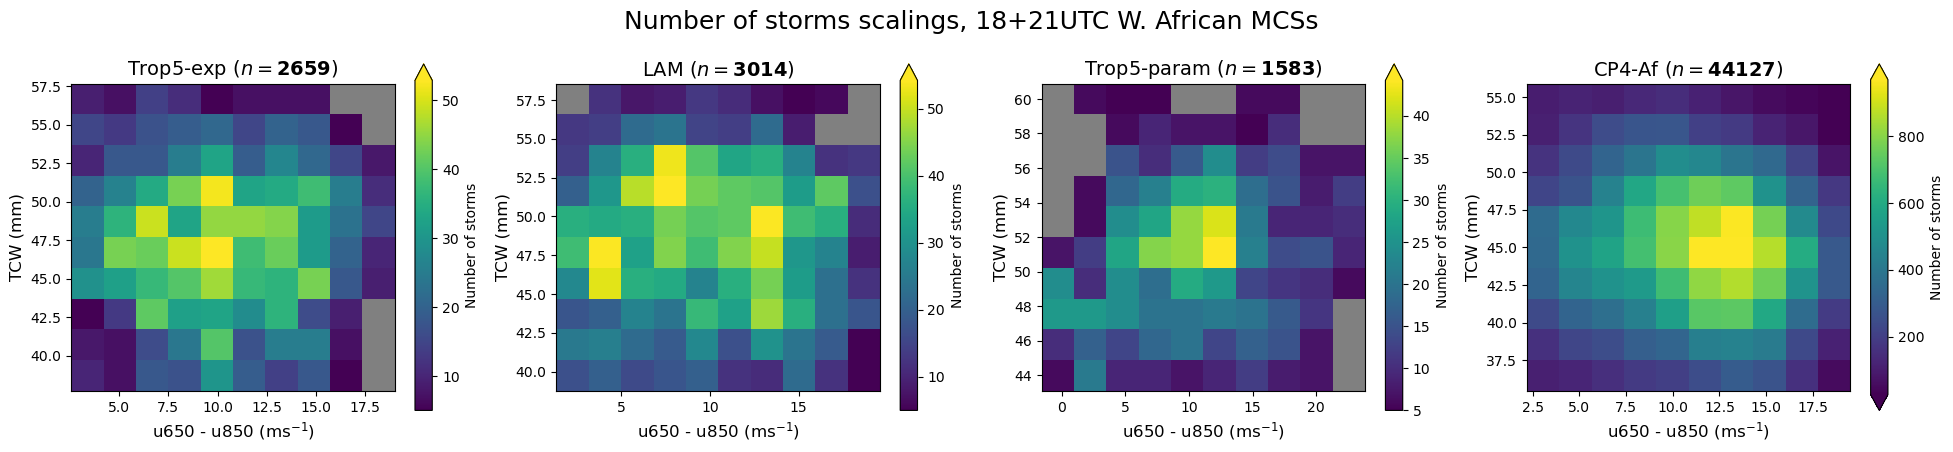

In [39]:
model_histograms([MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["CP4"]],
                 ["Trop5-exp","LAM","Trop5-param","CP4-Af"],"count",cmap="Blues",cut_off=5,com_scale=False,moist_var="tcw",max_pcle=0.95,min_pcle=0.05)

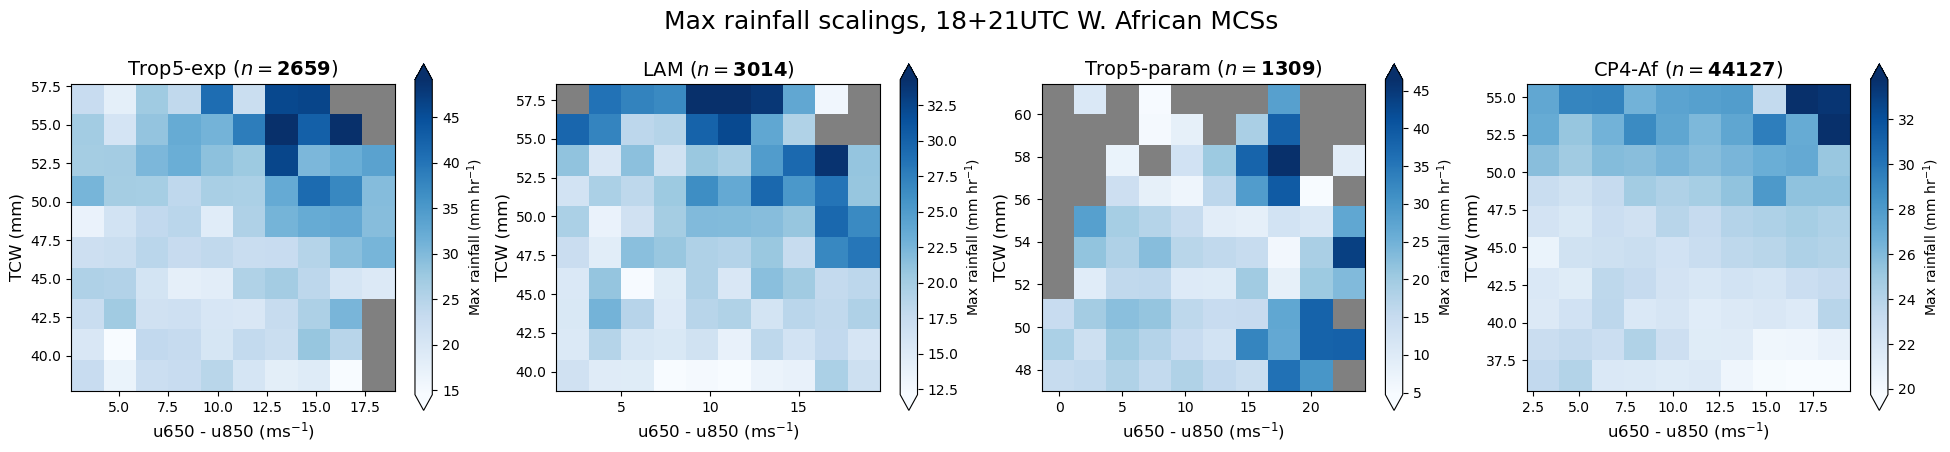

In [40]:
model_histograms([MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["Channel_GAL9"][MCS_data_dict["Channel_GAL9"]["tcw"]>47],MCS_data_dict["CP4"]],
                 ["Trop5-exp","LAM","Trop5-param","CP4-Af"],"rain_max",cmap="Blues",cut_off=5,com_scale=False,moist_var="tcw",max_pcle=0.95,min_pcle=0.05)

Text(0.02, 0.455, 'b)')

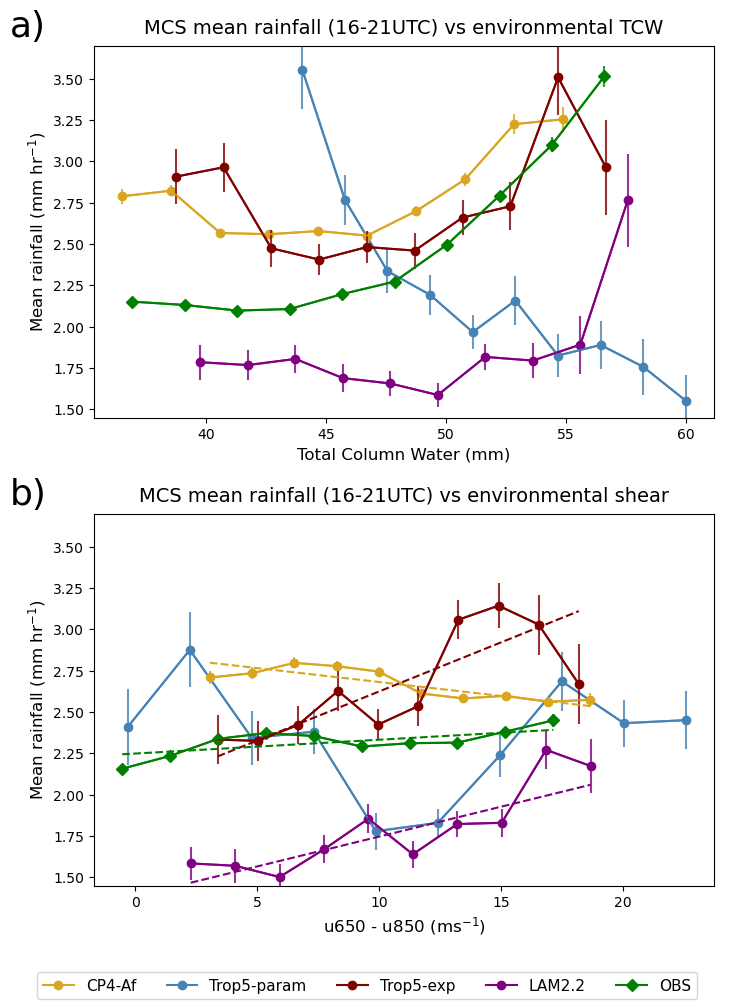

In [41]:
moist_var,shear_var="tcw","ushear650_850"
rain_var="rain_mean"
if rain_var=="rain_mean":
    ylab,ylim=r"Mean rainfall (mm hr$^{-1}$)",(1.45,3.7)
elif rain_var=="rain_area_tot":
    ylab,ylim=r"Total rainfall (mm km$^2$ hr$^{-1}$)",(30000,210000)
    
fig,ax=plt.subplots(2,figsize=(8,11))
ax[0]=multi_fits(ax[0],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["OBS"]],
                 ["a","b","c","d","e"],rain_var,moist_var,shear_var,lobf=[0,0,0,0,0],errs="bars",cut_off=5,grid_spec=10,max_pcle=0.95,min_pcle=0.05)
ax[0].set_xlabel("Total Column Water (mm)",fontsize=12)
ax[0].set_ylabel(ylab,fontsize=12)
ax[0].get_legend().remove()
ax[0].set_box_aspect(0.6)
ax[0].set_title("MCS {} rainfall (16-21UTC) vs environmental TCW".format(rain_var.split("_")[-1]),fontsize=14,y=1.01)
ax[0].set_ylim([ylim[0],ylim[1]])
#ax[0].set_ylim([0,12000])
ax[1]=multi_fits(ax[1],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["OBS"]],
                 ["a","b","c","d","e"],rain_var,shear_var,moist_var,lobf=None,errs="bars",cut_off=5,grid_spec=10,max_pcle=0.95,min_pcle=0.05)
ax[1].set_xlabel(r"u650 - u850 (ms$^{-1}$)",fontsize=12)
ax[1].set_ylabel(ylab,fontsize=12)
ax[1].get_legend().remove()
ax[1].set_box_aspect(0.6)
ax[1].set_ylim([ylim[0],ylim[1]])
#ax[1].set_ylim([1.5,3.4])
#ax[1].set_yticks([1,1.5,2,2.5])
ax[1].set_title("MCS {} rainfall (16-21UTC) vs environmental shear".format(rain_var.split("_")[-1]),fontsize=14,y=1.01)
#ax[1].set_ylim([8,38])
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='LAM2.2'),
                   Line2D([],[],color="green", marker="D", label='OBS')]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(bottom=0.1)
fig.legend(handles=legend_elements, fontsize='11', ncol=5, loc="lower center")#bbox_to_anchor=(0.4, 0.01))
plt.figtext(0.02,0.88,"a)",fontsize=26)
plt.figtext(0.02,0.455,"b)",fontsize=26)
#fig.savefig("fig4a.png".format(rain_var.split("_")[-1]),dpi=250,bbox_inches="tight",facecolor="white")

In [42]:
print("Correlation of OBS mean rain against shear")
bin_rain,mod_popt,mod_pcov=fit_trend(MCS_data_dict["OBS"],"rain_mean",rval=True)
tval=abs(mod_popt[1])/np.sqrt(mod_pcov[1])
p = stats.distributions.t.sf(tval, len(bin_rain)-2) * 2
print(p)
print("Ratio of Lam mean anvil area to OBS mean")
MCS_data_dict["Lam"]["area"].mean()/MCS_data_dict["OBS"]["area"].mean()

Correlation of OBS mean rain against shear
PearsonRResult(statistic=0.8258718952016723, pvalue=0.003241131765298686)
0.00013699315227830771
Ratio of Lam mean anvil area to OBS mean


1.19642171690824

In [43]:
shear,q="ushear650_850","tcw"
var="rain_mean"
print("Ratio of model 1D trend gradient OBS: {} response to ".format(var.replace("_"," "))+shear)
for sim in list(MCS_data_dict.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dict[sim]
    bin_rain,mod_popt,mod_pcov=fit_trend(MCS_data,var,max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q,rval=True)
    bin_obs,obs_popt,obs_pcov=fit_trend(MCS_data_dict["OBS"],var,max_pcle=0.95,min_pcle=0.05,bin_var=shear,red_var=q)
    print("Mean square error %.3f" % (1/(len(bin_rain)-2) * np.sum((bin_rain - (mod_popt[0]+mod_popt[1]*bin_rain.x))**2)))
    print("\delta / \delta_{OBS} = %.3f +/- %.3f" %(mod_popt[1]/obs_popt[1], (mod_popt[1]/obs_popt[1])*np.sqrt((np.sqrt(mod_pcov[1])/mod_popt[1])**2 + (np.sqrt(obs_pcov[1])/obs_popt[1])**2)))

    tval=abs(mod_popt[1] - obs_popt[1])/np.sqrt(mod_pcov[1])
    p = stats.distributions.t.sf(tval, len(bin_rain)-2) * 2
    print("t test for difference between model and OBS gradient gives p = %.3f"%p)

Ratio of model 1D trend gradient OBS: rain mean response to ushear650_850
Channel_GAL9
PearsonRResult(statistic=-0.07677319981591456, pvalue=0.8330449969966589)
Fit gradient not p<0.05 significant 0.467 < 2.306 , p = 0.653
Mean square error 0.168
\delta / \delta_{OBS} = 0.434 +/- 0.931
t test for difference between model and OBS gradient gives p = 0.559
Channel_RAL3
PearsonRResult(statistic=0.7623381353787483, pvalue=0.010357901001076024)
Mean square error 0.050
\delta / \delta_{OBS} = 7.100 +/- 1.715
t test for difference between model and OBS gradient gives p = 0.001
CP4
PearsonRResult(statistic=-0.8257393022919809, pvalue=0.003250462902791124)
Mean square error 0.003
\delta / \delta_{OBS} = -2.013 +/- -0.435
t test for difference between model and OBS gradient gives p = 0.000
Lam
PearsonRResult(statistic=0.8622806151795902, pvalue=0.0013283668396673678)
Mean square error 0.021
\delta / \delta_{OBS} = 4.322 +/- 1.055
t test for difference between model and OBS gradient gives p = 0.00

In [44]:
rain_var="rain_mean"
for sim in list(MCS_data_dictw.keys())[:-1]:
    print(sim)
    MCS_data=MCS_data_dictw[sim]
    bin_rain=fit_trend(MCS_data,"w_eff",max_pcle=0.95,min_pcle=0.05)
    bin_cores=fit_trend(MCS_data,rain_var,max_pcle=0.95,min_pcle=0.05)
    print("weff vs", rain_var, stats.pearsonr(bin_rain[0].values,bin_cores[0].values))
    bin_rain=fit_trend(MCS_data,"btdiff",max_pcle=0.95,min_pcle=0.05)
    bin_cores=fit_trend(MCS_data,rain_var,max_pcle=0.95,min_pcle=0.05)
    print("BTdiff vs", rain_var, stats.pearsonr(bin_rain[0].values,bin_cores[0].values))
    bin_rain=fit_trend(MCS_data,"area_w500_p99_core",max_pcle=0.95,min_pcle=0.05)
    bin_cores=fit_trend(MCS_data,rain_var,max_pcle=0.95,min_pcle=0.05)
    print("Core area vs", rain_var, stats.pearsonr(bin_rain[0].values,bin_cores[0].values))

Channel_GAL9
Fit gradient not p<0.05 significant 0.782 < 2.306 , p = 0.457
Fit gradient not p<0.05 significant 0.435 < 2.306 , p = 0.675
weff vs rain_mean PearsonRResult(statistic=0.5560891855159596, pvalue=0.09506676277555685)
Fit gradient not p<0.05 significant 1.227 < 2.306 , p = 0.255
Fit gradient not p<0.05 significant 0.435 < 2.306 , p = 0.675
BTdiff vs rain_mean PearsonRResult(statistic=-0.5174419927348609, pvalue=0.125576063563691)
Fit gradient not p<0.05 significant 0.435 < 2.306 , p = 0.675
Core area vs rain_mean PearsonRResult(statistic=0.05224697168561683, pvalue=0.8860212221486753)
Channel_RAL3
weff vs rain_mean PearsonRResult(statistic=0.9019113995246172, pvalue=0.00035924763969780627)
BTdiff vs rain_mean PearsonRResult(statistic=-0.784483982356516, pvalue=0.007209858234439252)
Core area vs rain_mean PearsonRResult(statistic=0.5615511106167758, pvalue=0.0911804952813213)
CP4
weff vs rain_mean PearsonRResult(statistic=-0.7387834491592743, pvalue=0.014653508598515831)
BTdif

In [45]:
def rmse(y,o):
    return np.sqrt(1/len(y) * np.sum((y-o)**2))

def MCS_dist_plotter(MCS_datas,var,sim="",region="Wafrica",cmap="viridis",vmax=0,vmin=0,ax=None,cbar=True,latlonspec=1,lab=None,dropna=False,save=False):
    if type(MCS_datas) != list:
        MCS_datas=[MCS_datas]
    spatial_bins=[]
    for MCS_data in MCS_datas:
        if dropna==True and var!="count":
            MCS_data=MCS_data[["clat","clon","tcw",var]].dropna(axis=0)
    
        da=spatial_binning(MCS_data,var=var,res=latlonspec)
        if vmax==0 and vmin==0:
            vmax=da.quantile(.99)
            vmin=da.quantile(.01)
        spatial_bins.append(da.T)
    if lab==None:
        lab=var.capitalize().replace("_"," ")
    if ax==None:
        fig,ax=plt.subplots(figsize=(9,6),subplot_kw=dict(projection=ccrs.PlateCarree()))
    if len(MCS_datas)==1:
        spatial_bins[0].plot(ax=ax,add_colorbar=cbar,cbar_kwargs={"shrink":0.8,"label":lab},vmax=vmax,vmin=vmin,cmap=cmap)
    else:
        if cbar==False:
            (spatial_bins[0] - spatial_bins[1]).plot(ax=ax,add_colorbar=False,vmax=vmax,vmin=vmin,cmap=cmap)
        else:
            (spatial_bins[0] - spatial_bins[1]).plot(ax=ax,cbar_kwargs={"shrink":0.8,"label":lab},vmax=vmax,vmin=vmin,cmap=cmap)
        comp=np.isnan(spatial_bins[0].values - spatial_bins[1].values)
        print("r,p = ",stats.pearsonr(spatial_bins[0].values[~comp].flatten(),spatial_bins[1].values[~comp].flatten()))
        print("RMSE = ",rmse(spatial_bins[0].values[~comp].flatten(),spatial_bins[1].values[~comp].flatten()))
        print("Mean = ",float((spatial_bins[0]-spatial_bins[1]).mean()))
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_patch(mpatch.Rectangle((-12,9),24,10,fill=False,lw=2,edgecolor="maroon"))
    ax.set_facecolor("lightgrey")
    #ax.add_patch(mpatch.Rectangle((-12,15),24,7,fill=False,lw=2,edgecolor="maroon"))
    #ax.add_patch(mpatch.Rectangle((-12,8),24,7,fill=False,lw=2,edgecolor="maroon"))
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,linestyle='--')
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    #gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120, 180])
    #gl.ylocator = mticker.FixedLocator([-20, 0, 20])
    if region=="Wafrica":
        gl.ylocator = mticker.FixedLocator([5,10,15,20])
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    ax.set_title("{}, {}. MCS (n={}) spatial distribution".format(sim.replace("_"," "),region,len(MCS_data)))
    #plt.show()    
    return ax

Bias mean, std error, stddev 6.960961411742462 2.5328659539239577 41.926391732534185
Lam
1 degree, shear: r=0.373 (0.127); R2 = 0.139
1 degree, tcw: r=-0.033 (0.896); R2 = 0.001
2.5 degrees, shear: r=0.668 (0.013); R2 = 0.447
2.5 degrees, tcw, tcw: r=0.355 (0.234); R2 = 0.126
Bias mean, std error, stddev 2.1959450801881535 4.336995021153278 60.8726259106763
Channel_GAL9
1 degree, shear: r=-0.221 (0.429); R2 = 0.049
1 degree, tcw: r=0.018 (0.949); R2 = 0.000
2.5 degrees, shear: r=0.261 (0.412); R2 = 0.068
2.5 degrees, tcw, tcw: r=0.542 (0.069); R2 = 0.294
Bias mean, std error, stddev 7.681534018679894 2.0645791932597626 34.731597867118644
CP4
1 degree, shear: r=-0.502 (0.001); R2 = 0.252
1 degree, tcw: r=-0.284 (0.062); R2 = 0.080
2.5 degrees, shear: r=-0.575 (0.040); R2 = 0.331
2.5 degrees, tcw, tcw: r=-0.518 (0.070); R2 = 0.269


Text(-22.5, 12.6, 'Sahel')

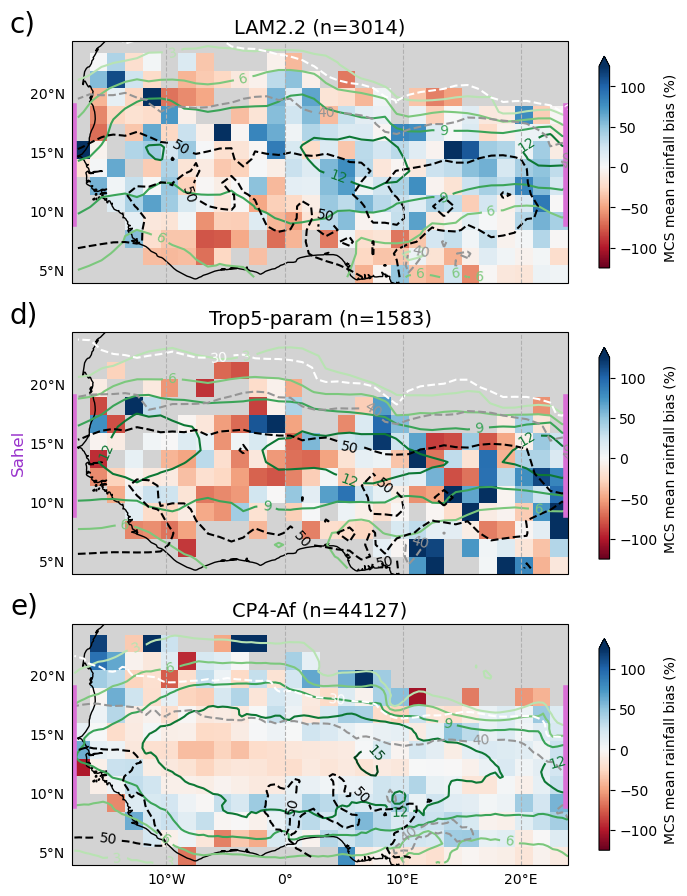

In [47]:
fig,axes=plt.subplots(3,figsize=(8,11),subplot_kw=dict(projection=ccrs.PlateCarree()),gridspec_kw={"hspace":0.1})
labs=["c)","d)","e)"]
lens,corrs=[],[]
mod="_anom"
rain_var="rain_mean"
res=1.5
for i, sim in enumerate(["Lam","Channel_GAL9","CP4"]):
    MCS_data=MCS_data_dict[sim].copy()
    plev=850
    MCS_data=MCS_data[MCS_data["psfc"]>plev]
    biases=spatial_binning(MCS_data,var=rain_var+mod,res=res,max_pcle=0.95,min_pcle=0.05) - spatial_binning(MCS_data_dict["OBS"].copy(),var=rain_var+mod,res=res,max_pcle=0.95,min_pcle=0.05)
    biases=biases/spatial_binning(MCS_data_dict["OBS"],var=rain_var,res=res,max_pcle=0.95,min_pcle=0.05)*100
    biases.T.plot(ax=axes[i],cmap="RdBu",cbar_kwargs={"shrink":0.8,"label":r"MCS {} rainfall bias (%)".format(rain_var.split("_")[-1])},vmax=125,vmin=-125)
    #biases.T.plot(ax=axes[i],cmap="RdBu",cbar_kwargs={"shrink":0.8,"label":r"Rainfall bias (mm km$^2$ hr$^{-1}$)"},vmax=1e5,vmin=-1e5)#,vmax=2.5,vmin=-2.5)
    #if i<2:
    #    env=xr.open_dataset("/gws/nopw/j04/lmcs/bmaybee/{}_{}_storm_env_fields.nc".format(sim,region.lower())).sel(longitude=slice(-18,25),latitude=slice(4,25))
    #    env=env.rename({"x_wind":"ushear650_850"})
    #else:
    env=xr.open_dataset("/gws/nopw/j04/lmcs/bmaybee/kscale_DYv1_analysis/{}_stormtimes_1deg_regrid.nc".format(sim)
                       ).sel(longitude=slice(-18,25),latitude=slice(4,25))
    Cshr=(-1*env.mean(dim="time").ushear650_850).plot.contour(ax=axes[i], levels=[3,6,9,12,15],kwargs=dict(inline=True),cmap=truncate_colormap(plt.get_cmap('Greens'), 0.3, 1))
    Ctcw=env.mean(dim="time").total_column_q.plot.contour(ax=axes[i], levels=[30,40,50], linestyles="dashed", kwargs=dict(inline=True,linestyle="--"),cmap="Greys")
    
    print("Bias mean, std error, stddev", float(biases.mean()),float(biases.std())/np.sqrt(float((~np.isnan(biases)).sum())),float(biases.std()))
    #coarse_lat=np.arange(biases.latitude.values[0],biases.latitude.values[-1],5)
    #coarse_lon=np.arange(biases.longitude.values[0],biases.longitude.values[-1],5)
    shear=-1*env.mean(dim="time").ushear650_850
    tcw=env.mean(dim="time").total_column_q
    b=biases.interp(latitude=shear.latitude,longitude=shear.longitude)
    s=shear.mean(dim="longitude")
    t=tcw.mean(dim="longitude")
    comp=np.isnan((b.mean(dim="longitude")-s).values)
    print(sim)
    r,p=stats.pearsonr(b.mean(dim="longitude")[~comp],s[~comp])
    print("1 degree, shear: r={:.3f} ({:.3f}); R2 = {:.3f}".format(r,p,r**2))
    r,p=stats.pearsonr(b.mean(dim="longitude")[~comp],t[~comp])
    print("1 degree, tcw: r={:.3f} ({:.3f}); R2 = {:.3f}".format(r,p,r**2))
    
    shear=shear.interp(latitude=biases.latitude,longitude=biases.longitude)
    tcw=tcw.interp(latitude=biases.latitude,longitude=biases.longitude)
    comp=np.isnan((biases.mean(dim="longitude")-shear.mean(dim="longitude")).values)
    r,p=stats.pearsonr(biases.mean(dim="longitude")[~comp],shear.mean(dim="longitude")[~comp])
    print("2.5 degrees, shear: r={:.3f} ({:.3f}); R2 = {:.3f}".format(r,p,r**2))
    r,p=stats.pearsonr(biases.mean(dim="longitude")[~comp],tcw.mean(dim="longitude")[~comp])
    print("2.5 degrees, tcw, tcw: r={:.3f} ({:.3f}); R2 = {:.3f}".format(r,p,r**2))
    
    axes[i].clabel(Cshr)
    axes[i].clabel(Ctcw)
    axes[i].coastlines()
    gl = axes[i].gridlines(crs = ccrs.PlateCarree(),draw_labels=True,linestyle="--")
    #gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    if i<2:
        gl.bottom_labels=False
    gl.ylocator = mticker.FixedLocator([5,10,15,20])
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    axes[i].set_facecolor("lightgrey")
    axes[i].text(-0.125,1.04,labs[i],fontsize=20,transform=axes[i].transAxes)
    axes[i].plot((-17.8,-17.8),(9,19),color="orchid",linewidth=4)
    axes[i].set_xlim([-18,24])
    axes[i].plot((23.8,23.8),(9,19),color="orchid",linewidth=4)
    lens.append(len(MCS_data))
    #axes[i].set_xlim([-17.5,24.5])
    #axes[i].set_ylim([4.5,24.5])
axes[0].set_title("LAM2.2 (n=%s)"%lens[0],fontsize=14)
axes[1].set_title("Trop5-param (n=%s)"%lens[1],fontsize=14)
axes[2].set_title("CP4-Af (n=%s)"%lens[2],fontsize=14)
axes[1].text(-22.5,12.6,"Sahel",rotation="vertical",ha="center",fontsize=12,color="darkorchid")
#fig.savefig("fig4c.png",dpi=250,bbox_inches="tight",facecolor="white")

In [49]:
print("Conversion of OBS shear scalings into heating power")
bin_t,t_popt,t_pcov=fit_trend(MCS_data_dict["OBS"],"tmean",max_pcle=0.95,min_pcle=0.05)
bin_r,r_popt,r_pcov=fit_trend(MCS_data_dict["OBS"],"rain_mean",max_pcle=0.95,min_pcle=0.05)

sigma=5.670373e-8
levap=2260e3
print("tmean scaling = %.4f, rmean scaling =%.4f"%(t_popt[1],r_popt[1]))
print("P_anvil=",sigma*t_popt[1]**4) # Stefan Boltzmann law applied to trend in anvil T, W m-2 / ms-1
print("P_rain=",levap * r_popt[1] / 3600) # Latent heat of evaporation of water for trend in mean rainfall, converted from /hr to /s

Conversion of OBS shear scalings into heating power
tmean scaling = -0.2377, rmean scaling =0.0084
P_anvil= 1.8092428308655753e-10
P_rain= 5.250701587238298


SUPPLEMENTARY

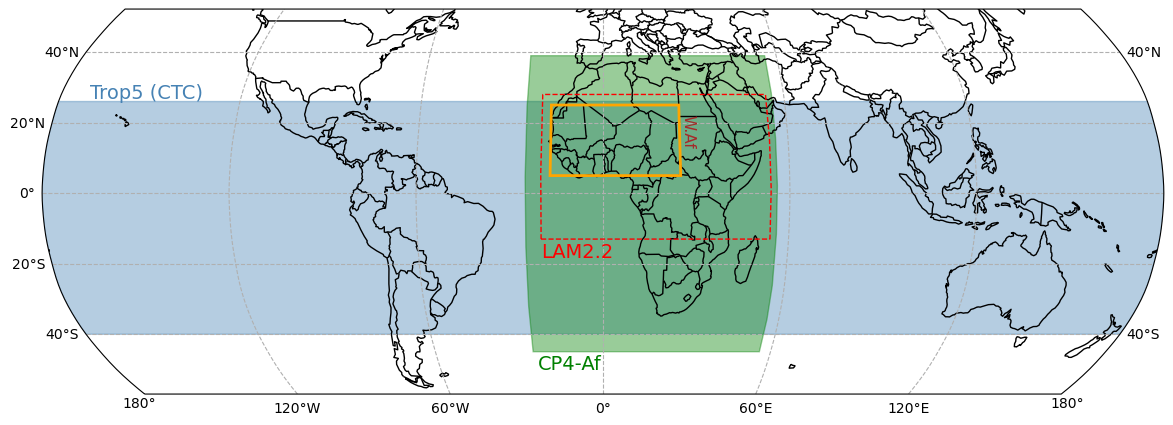

In [52]:
lat=np.arange(-55,55,5)
lon=np.arange(-180,180,5)
da=xr.DataArray(np.zeros((len(lat),len(lon))),coords=[lat,lon],dims=["latitude","longitude"])

fig,ax=plt.subplots(figsize=(15,5),subplot_kw={"projection":ccrs.Robinson()})
da.where(da!=0).plot(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_patch(mpatch.Rectangle((-180,-40),360,66,color="steelblue",alpha=0.4,transform=ccrs.PlateCarree()))
ax.text(-170, 27, 'Trop5 (CTC)',transform=ccrs.PlateCarree(),color="steelblue",size=14)
ax.add_patch(mpatch.Rectangle((-25,-45),81,84,color="green",alpha=0.4,transform=ccrs.PlateCarree()))
ax.text(-24, -50, 'CP4-Af',transform=ccrs.PlateCarree(),color="green",size=14)
ax.add_patch(mpatch.Rectangle((-17,5),42,20,fill=False,lw=2,edgecolor="orange",transform=ccrs.PlateCarree(),zorder=999))
#ax.text(24, 26, 'W.Af',horizontalalignment="right",transform=ccrs.PlateCarree(),color="brown",size=11)
ax.text(25.2, 13.8, 'W.Af',rotation=270,transform=ccrs.PlateCarree(),color="brown",size=11)
ax.add_patch(mpatch.Rectangle((-20,-13),74,41,fill=False,ls="--",edgecolor="red",transform=ccrs.PlateCarree(),zorder=999))
ax.text(-20, -18, 'LAM2.2',transform=ccrs.PlateCarree(),color="red",size=14)
#ax.add_patch(mpatch.Rectangle((-15,-37),67,49,fill=False,ls="--",edgecolor="red",transform=ccrs.PlateCarree()))
#ax.text(-14, -35, 'LAM Africa (x2)',rotation=90,transform=ccrs.PlateCarree(),color="red",size=12)
#ax.add_patch(mpatch.Rectangle((-86,-30),60,44,fill=False,ls="--",edgecolor="red",transform=ccrs.PlateCarree()))
#ax.text(-92, -16, 'LAM S.Amer.',rotation=90,transform=ccrs.PlateCarree(),color="red",size=12)
#ax.add_patch(mpatch.Rectangle((90,-18),64,43,fill=False,ls="--",edgecolor="red",transform=ccrs.PlateCarree()))
#ax.text(153, 20, 'LAM SEA',verticalalignment="bottom",horizontalalignment="right",transform=ccrs.PlateCarree(),color="red",size=12)
#ax.add_patch(mpatch.Rectangle((65,3.5),36,36.5,fill=False,ls="--",edgecolor="red",transform=ccrs.PlateCarree()))
#ax.text(98, 31, 'LAM\nIndia',horizontalalignment="right",transform=ccrs.PlateCarree(),color="red",size=12)
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,linestyle='--')
#gl.xlines = False
#gl.ylines = False
gl.top_labels = False
gl.right_labels = False
#gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120, 180])
#gl.ylocator = mticker.FixedLocator([-20, 0, 20])
#if region=="Wafrica":
#    gl.ylocator = mticker.FixedLocator([5,10,15,20])
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
plt.show()
#fig.savefig("figS1.png",dpi=200,bbox_inches="tight",facecolor="white")

Text(0.5, 0.94, 'Spatial distribution, 16-21UTC W. African MCSs')

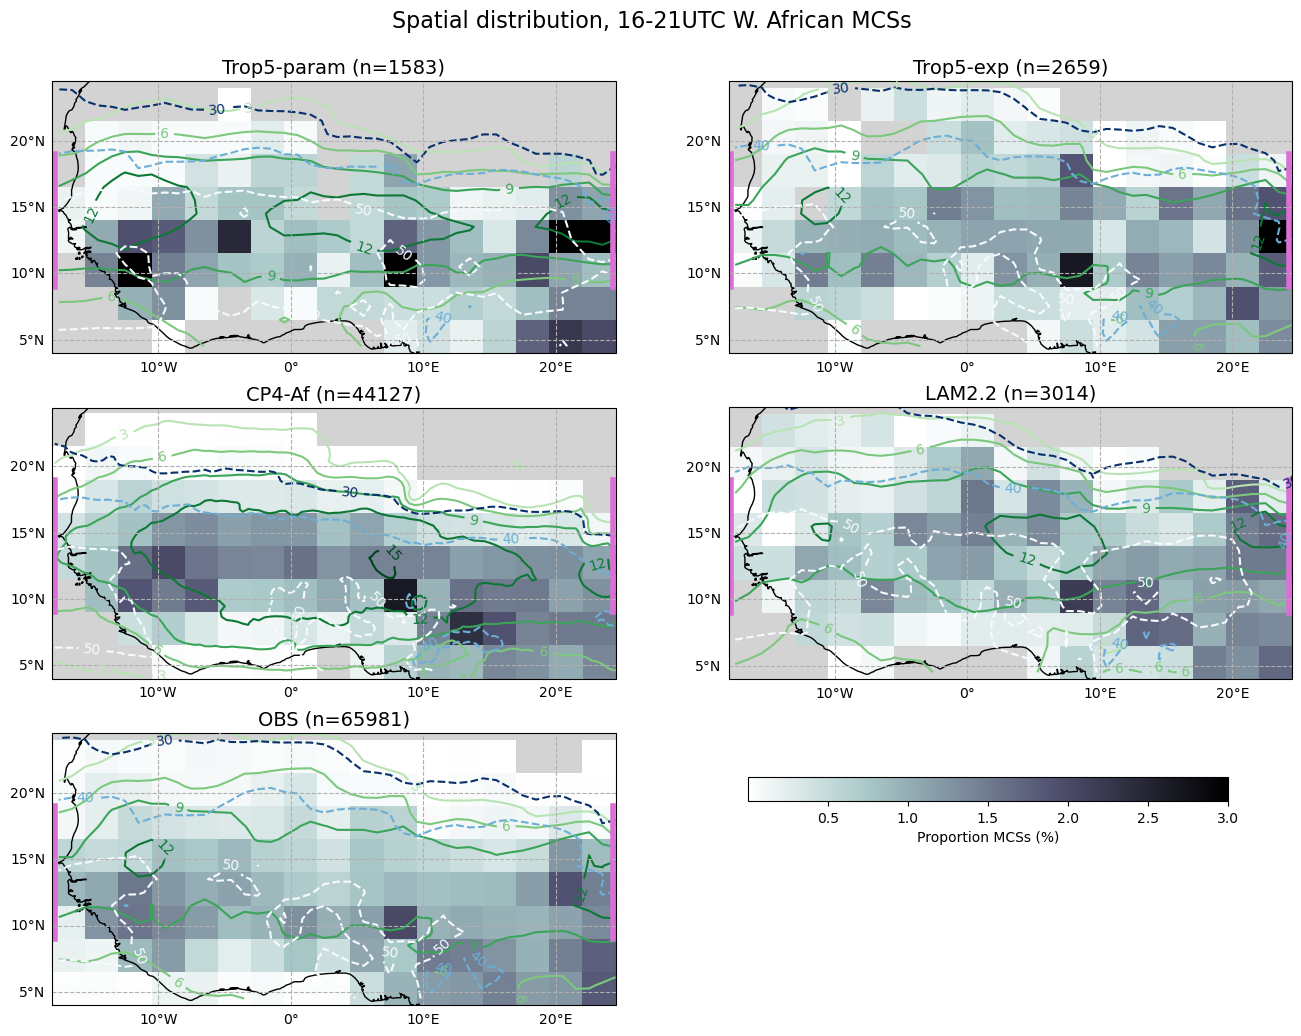

In [53]:
fig,axes=plt.subplots(3,2,figsize=(16,12),subplot_kw=dict(projection=ccrs.PlateCarree()))
sims=list(MCS_data_dict.keys())
for i,sim in enumerate(sims):
    da=100*spatial_binning(MCS_data_dict[sim],res=2.5,max_pcle=0.95,min_pcle=0.05)/len(MCS_data_dict[sim])
    #if sim=="OBS":
    #    da.where(da>0).T.plot(ax=axes.T.flatten()[i],vmax=da.quantile(.99),cmap="Greens",cbar_kwargs={"shrink":0.6})
    #else:
    cb=da.where(da>5/len(MCS_data_dict[sim])).T.plot(ax=axes.flatten()[i],vmax=3,add_colorbar=False,cmap="bone_r")
    if sim=="OBS":
        sim="Channel_RAL3"
    env=xr.open_dataset("/gws/nopw/j04/lmcs/bmaybee/kscale_DYv1_analysis/{}_stormtimes_1deg_regrid.nc".format(sim)
                       ).sel(longitude=slice(-18,25),latitude=slice(4,25))
    Cshr=(-1*env.mean(dim="time").ushear650_850).plot.contour(ax=axes.flatten()[i], levels=[3,6,9,12,15],kwargs=dict(inline=True),cmap=truncate_colormap(plt.get_cmap('Greens'), 0.3, 1))
    Ctcw=env.mean(dim="time").total_column_q.plot.contour(ax=axes.flatten()[i], levels=[30,40,50], linestyles="dashed", kwargs=dict(inline=True,linestyle="--"),cmap="Blues_r")
    axes.flatten()[i].clabel(Cshr)
    axes.flatten()[i].clabel(Ctcw)

labs=["Trop5-param","Trop5-exp","CP4-Af","LAM2.2","OBS"]
for i, ax in enumerate(axes.flatten()):
    if i==5:
        ax.axis("off")
        continue
    ax.coastlines()
    #ax.add_feature(cfeature.BORDERS)
    #ax.add_patch(mpatch.Rectangle((-12,9),24,10,fill=False,lw=2,edgecolor="maroon"))
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,linestyle='--')
    #gl.xlines = False
    #gl.ylines = False
    gl.ylocator = mticker.FixedLocator([5,10,15,20])
    gl.top_labels = False
    gl.right_labels = False
    #gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120, 180])
    #gl.ylocator = mticker.FixedLocator([-20, 0, 20])
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    ax.set_facecolor("lightgrey")
    ax.plot((-17.8,-17.8),(9,19),color="orchid",linewidth=4)
    ax.set_xlim([-18,24.5])
    ax.plot((24.3,24.3),(9,19),color="orchid",linewidth=4)
    #ax.set_title("{} (n={})".format(hierarchy[i].replace("_"," ")))
    tit=labs[i]+" (n={})".format(len(MCS_data_dict[sims[i]]))
    ax.set_title(tit,fontsize=14)

cax = fig.add_axes([0.56,0.28,0.3,0.02])
fig.colorbar(cb, cax = cax, orientation = "horizontal", label = "Proportion MCSs (%)")
fig.suptitle("Spatial distribution, 16-21UTC W. African MCSs",fontsize=16,y=0.94)
#fig.savefig("figS2.png",dpi=250,bbox_inches="tight",facecolor="white")

In [55]:
MCS_data_dict["Channel_GAL9"]["rain_max_diff"]=MCS_data_dict["Channel_GAL9"]["rain_max"]-MCS_data_dict["Channel_GAL9"]["convrain_max"]
MCS_data_dict["Channel_GAL9"]["rain_mean_diff"]=MCS_data_dict["Channel_GAL9"]["rain_mean"]-MCS_data_dict["Channel_GAL9"]["convrain_mean"]

Text(0.642, 0.86, 'c)')

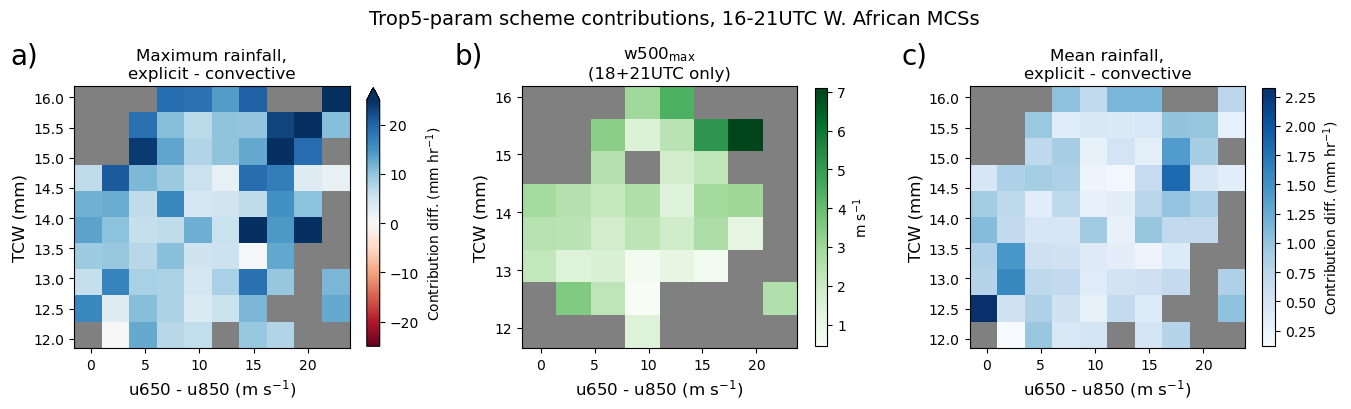

In [56]:
fig,axes=plt.subplots(1,3,figsize=(16,4.2),gridspec_kw={"wspace":0.3})
moist_var,shear_var="q850","ushear650_850"
grid_spec,min_pcle,max_pcle=10,0.05,0.95
hist=bin_2d(MCS_data_dict["Channel_GAL9"],moist_var=moist_var,shear_var=shear_var,
            rain_var="rain_max_diff",t_var="tmin",grid_spec=grid_spec,min_pcle=min_pcle,max_pcle=max_pcle)
hist[0].where(hist[3]>=5).plot(ax=axes[0],cmap="RdBu",vmax=25,cbar_kwargs={"label":"Contribution diff. (mm hr$^{-1}$)","shrink":0.8})
axes[0].set_title("Maximum rainfall,\nexplicit - convective",fontsize=12)

hist=bin_2d(MCS_data_dictw["Channel_GAL9"],moist_var=moist_var,shear_var=shear_var,
            rain_var="max_w500",t_var="tmin",grid_spec=8,min_pcle=min_pcle,max_pcle=max_pcle)
hist[0].where(hist[3]>=5).plot(ax=axes[1],cmap="Greens",cbar_kwargs={"label":r"m s$^{-1}$","shrink":0.8})
axes[1].set_title(r"w500$_{\rm max}$"+"\n(18+21UTC only)",fontsize=12)

hist=bin_2d(MCS_data_dict["Channel_GAL9"],moist_var=moist_var,shear_var=shear_var,
            rain_var="rain_mean_diff",t_var="tmin",grid_spec=grid_spec,min_pcle=min_pcle,max_pcle=max_pcle)
hist[0].where(hist[3]>=5).plot(ax=axes[2],cmap="Blues",cbar_kwargs={"label":"Contribution diff. (mm hr$^{-1}$)","shrink":0.8})
axes[2].set_title("Mean rainfall,\nexplicit - convective",fontsize=12)

for ax in axes:
    ax.set_xlabel("u650 - u850 (m s$^{-1}$)",fontsize=12)
    ax.set_ylabel("TCW (mm)",fontsize=12)
    ax.set_box_aspect(0.95)
    ax.set_facecolor("grey")
fig.suptitle("Trop5-param scheme contributions, 16-21UTC W. African MCSs",fontsize=14,y=0.99)
plt.figtext(0.085,0.86,"a)",fontsize=20)
plt.figtext(0.363,0.86,"b)",fontsize=20)
plt.figtext(0.642,0.86,"c)",fontsize=20)
#plt.savefig("figS3.png",dpi=200,bbox_inches="tight",facecolor="white")

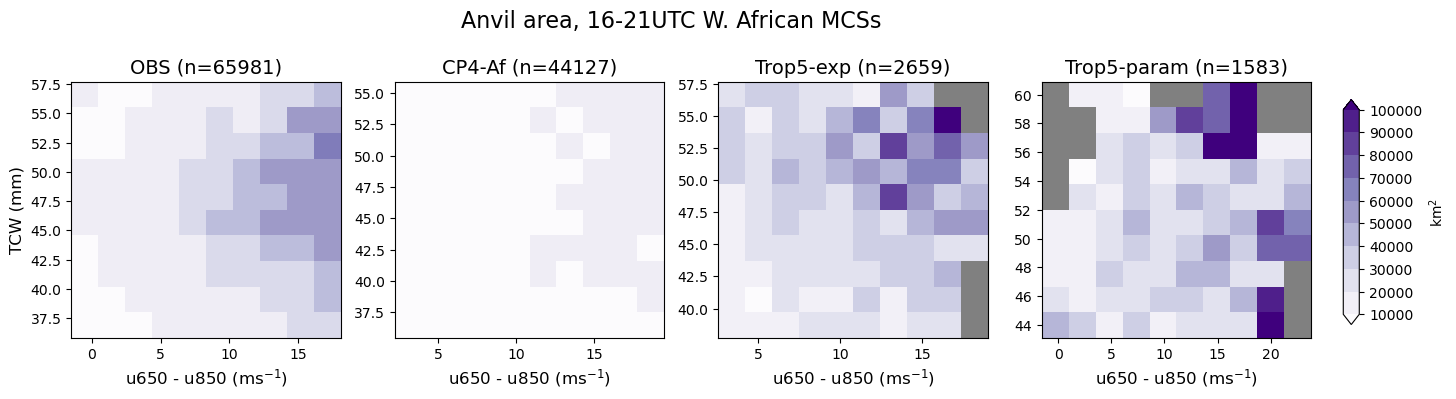

Text(0.52, 0.8, 'c)')

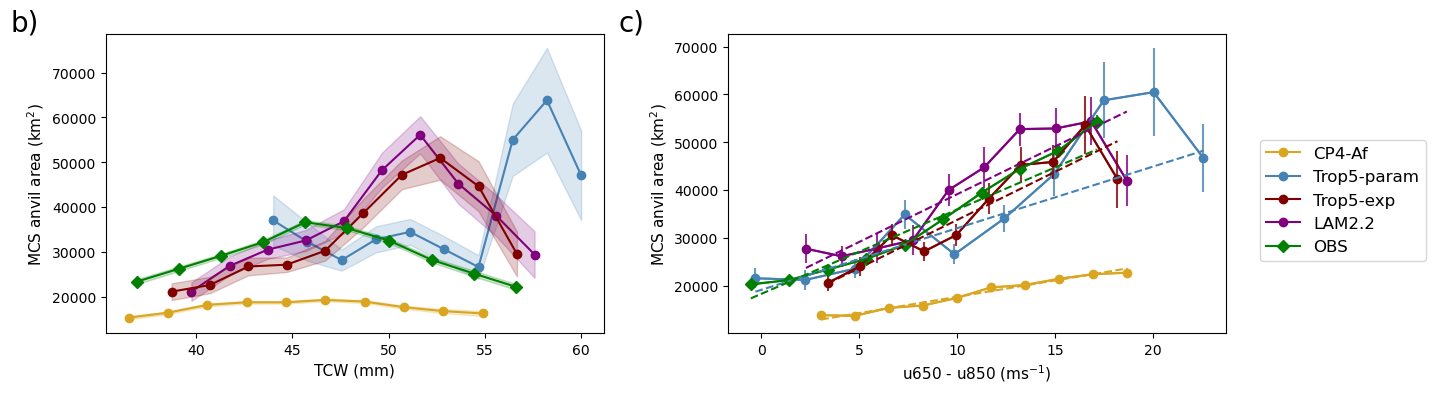

In [57]:
hierarchy_var_comparison(MCS_data_dict,"area",max_pcle=0.95,min_pcle=0.05,grid_spec=10)#,save="S4a")

moist_var,shear_var="tcw","ushear650_850"
fig,ax=plt.subplots(1,2,figsize=(16,5),gridspec_kw={"wspace":0.25})
ax[0]=multi_fits(ax[0],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["OBS"]],
                 ["a","b","c","d","e"],"area",moist_var,shear_var,lobf=[0,0,0,0,0],cut_off=5,max_pcle=0.95,min_pcle=0.05)
ax[0].set_box_aspect(0.6)
ax[0].set_xlabel(r"TCW (mm)",fontsize=11)
ax[0].set_ylabel(r"MCS anvil area (km$^2$)",fontsize=11)
ax[0].get_legend().remove()
#ax[0].set_ylim([50,275])
#ax[0].set_title("Max w500 vs environmental shear",fontsize=14)
#ax[0].set_ylim([0,12000])
#ax[1].axhline(0,alpha=0.4,color="k")
ax[1]=multi_fits(ax[1],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["OBS"]],
                 ["a","b","c","d","e"],"area",shear_var,moist_var,lobf=None,cut_off=5,max_pcle=0.95,min_pcle=0.05,errs="bars")
ax[1].set_box_aspect(0.6)
ax[1].set_xlabel(r"u650 - u850 (ms$^{-1}$)",fontsize=11)
ax[1].set_ylabel(r"MCS anvil area (km$^2$)",fontsize=11)
#ax[1].set_title("Core buoyancy vs environmental shear",fontsize=14)
ax[1].get_legend().remove()
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='LAM2.2'),
                   Line2D([],[],color="green", marker="D", label='OBS')]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.2)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.03, 0.6))
plt.figtext(0.14,0.8,"b)",fontsize=20)
plt.figtext(0.52,0.8,"c)",fontsize=20)
#fig.savefig("figS4b.png",dpi=200,bbox_inches="tight",facecolor="white")

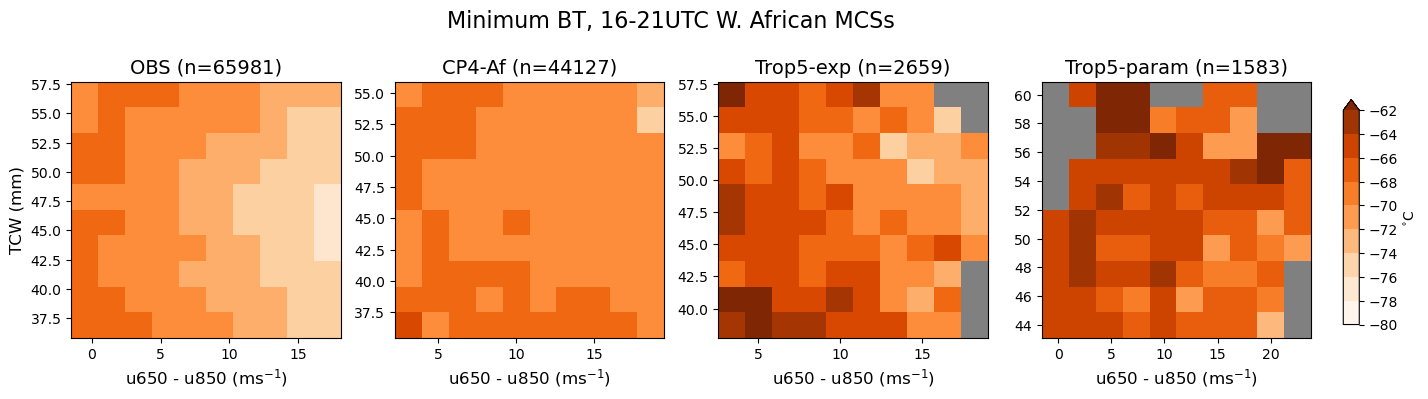

Text(0.535, 0.8, 'c)')

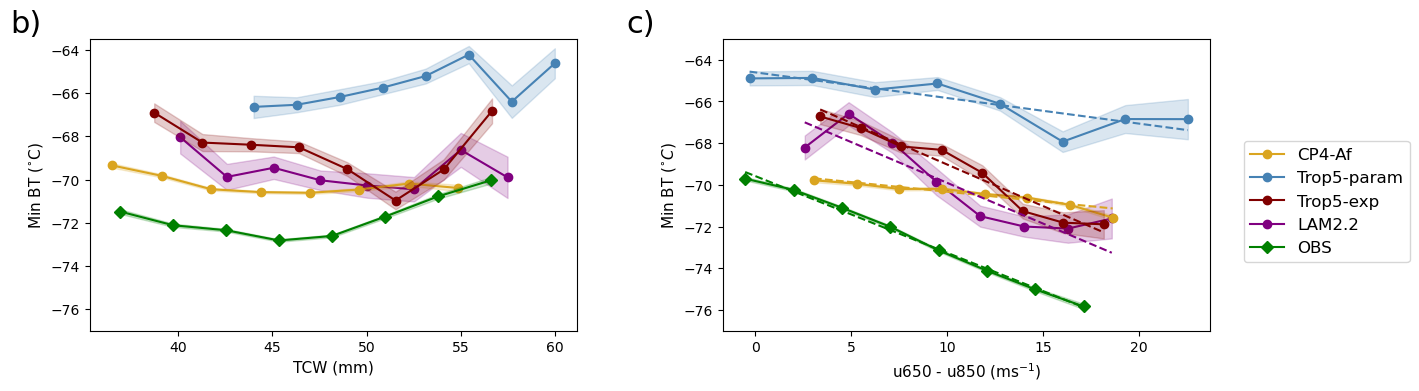

In [58]:
hierarchy_var_comparison(MCS_data_dict,"tmin",full=False,max_pcle=0.95,min_pcle=0.05,grid_spec=10)#,save="S5a")

moist_var,shear_var="tcw","ushear650_850"
fig,ax=plt.subplots(1,2,figsize=(16,5),gridspec_kw={"wspace":0.3})
ax[0]=multi_fits(ax[0],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dictw["Lam"],MCS_data_dict["OBS"]],
                 ["a","b","c","d","e"],"tmin",moist_var,shear_var,lobf=[0,0,0,0,0],cut_off=5,grid_spec=8,max_pcle=0.95,min_pcle=0.05)
ax[0].set_box_aspect(0.6)
ax[0].set_xlabel(r"TCW (mm)",fontsize=11)
ax[0].set_ylabel(r"Min BT ($^{\circ}$C)",fontsize=11)
ax[0].get_legend().remove()
ax[0].set_ylim([-77,-63.5])
#ax[0].set_ylim([50,275])
#ax[0].set_title("Max w500 vs environmental shear",fontsize=14)
#ax[0].set_ylim([0,12000])
#ax[1].axhline(0,alpha=0.4,color="k")
ax[1]=multi_fits(ax[1],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dictw["Lam"],MCS_data_dict["OBS"]],
                 ["a","b","c","d","e"],"tmin",shear_var,moist_var,lobf=None,cut_off=5,grid_spec=8,max_pcle=0.95,min_pcle=0.05)
ax[1].set_box_aspect(0.6)
ax[1].set_xlabel(r"u650 - u850 (ms$^{-1}$)",fontsize=11)
ax[1].set_ylabel(r"Min BT ($^{\circ}C$)",fontsize=11)
#ax[1].set_title("Core buoyancy vs environmental shear",fontsize=14)
ax[1].get_legend().remove()
ax[1].set_ylim([-77,-63])
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='LAM2.2'),
                   Line2D([],[],color="green", marker="D", label='OBS')]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.2)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.03, 0.6))
plt.figtext(0.15,0.8,"b)",fontsize=22)
plt.figtext(0.535,0.8,"c)",fontsize=22)
#fig.savefig("figS5b.png",dpi=200,bbox_inches="tight",facecolor="white")

Text(0.55, 0.8, 'c)')

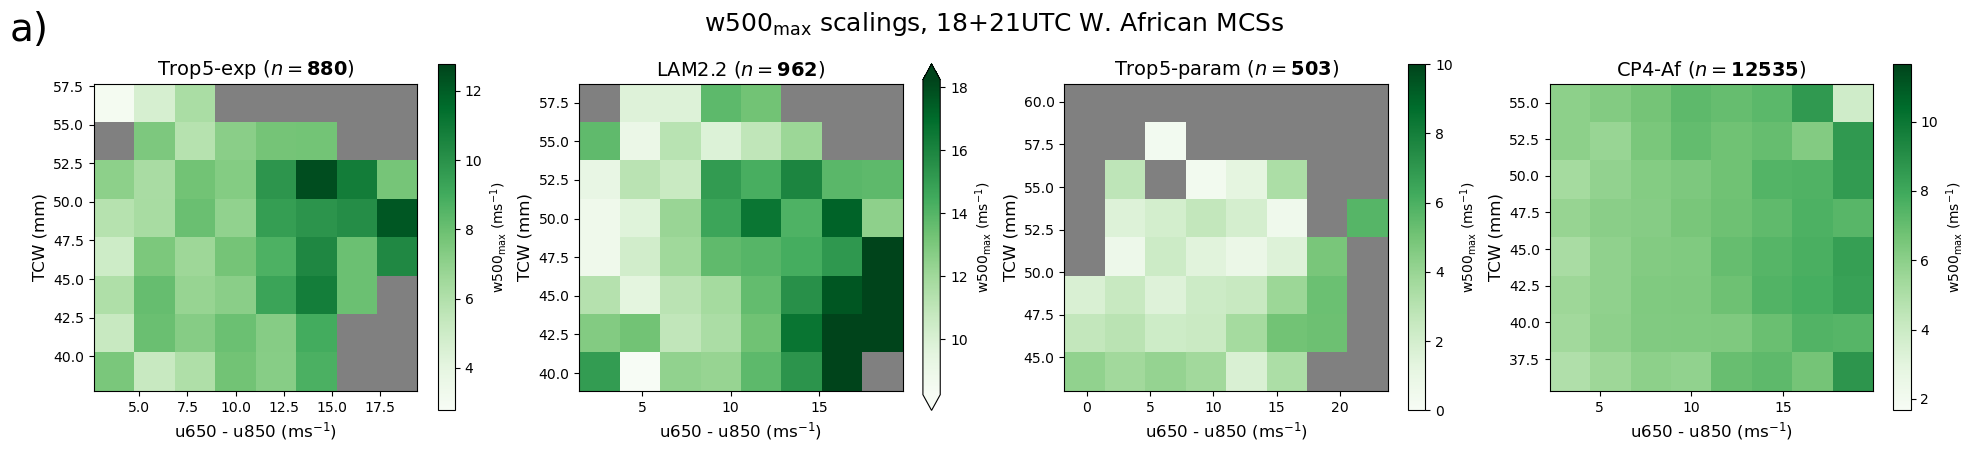

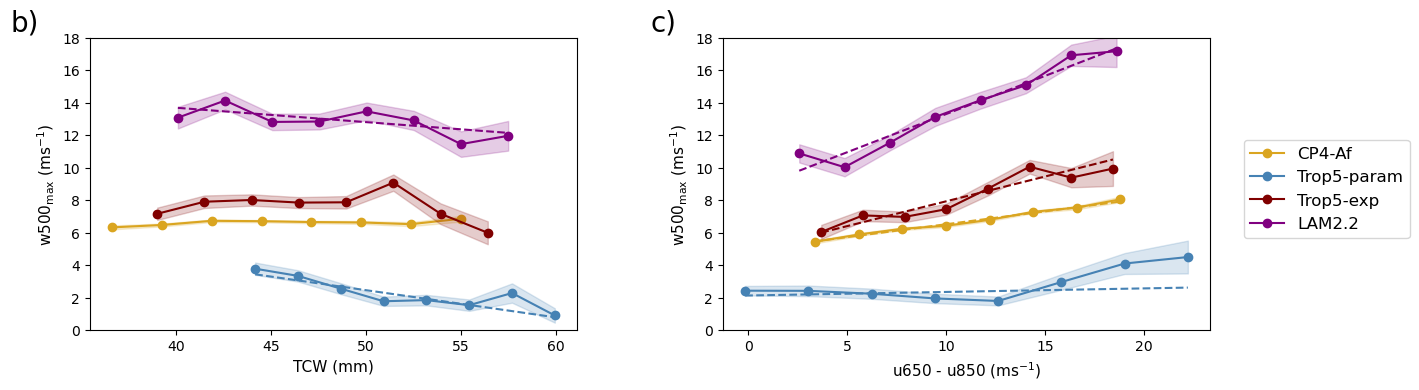

In [59]:
model_histograms([MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["CP4"]],["Trop5-exp","LAM2.2","Trop5-param","CP4-Af"],
                 "max_w500",moist_var="tcw",grid_spec=8,max_pcle=0.95,min_pcle=0.05,com_scale=10,save="S6a")

moist_var,shear_var="tcw","ushear650_850"
fig,ax=plt.subplots(1,2,figsize=(16,5),gridspec_kw={"wspace":0.3})
ax[0]=multi_fits(ax[0],[MCS_data_dictw["CP4"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"]],["a","b","c","d"],"max_w500",
                 moist_var,shear_var,lobf=None,cut_off=5,grid_spec=8,max_pcle=0.95,min_pcle=0.05)
ax[0].set_box_aspect(0.6)
#ax[0].set_xlabel(r"$\sqrt{\rm CAPE_{env}}$",fontsize=11)
ax[0].set_xlabel("TCW (mm)",fontsize=11)
ax[0].set_ylabel(r"w500$_{\rm max}$ (ms$^{-1}$)",fontsize=11)
ax[0].get_legend().remove()
ax[0].set_ylim([0,18])
#ax[0].set_ylim([50,275])
#ax[0].set_title("Max w500 vs environmental shear",fontsize=14)
#ax[0].set_ylim([0,12000])
#ax[1].axhline(0,alpha=0.4,color="k")
ax[1]=multi_fits(ax[1],[MCS_data_dictw["CP4"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"]],["a","b","c","d"],"max_w500",
                 shear_var,moist_var,lobf=None,cut_off=5,grid_spec=8,max_pcle=0.95,min_pcle=0.05)
ax[1].set_box_aspect(0.6)
ax[1].set_xlabel(r"u650 - u850 (ms$^{-1}$)",fontsize=11)
ax[1].set_ylabel(r"w500$_{\rm max}$ (ms$^{-1}$)",fontsize=11)
#ax[1].set_title("Core buoyancy vs environmental shear",fontsize=14)
ax[1].get_legend().remove()
ax[1].set_ylim([0,18])    
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='LAM2.2')]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.2)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.03, 0.6))
plt.figtext(0.15,0.8,"b)",fontsize=20)
plt.figtext(0.55,0.8,"c)",fontsize=20)
#fig.savefig("figS6b.png",dpi=200,bbox_inches="tight",facecolor="white")

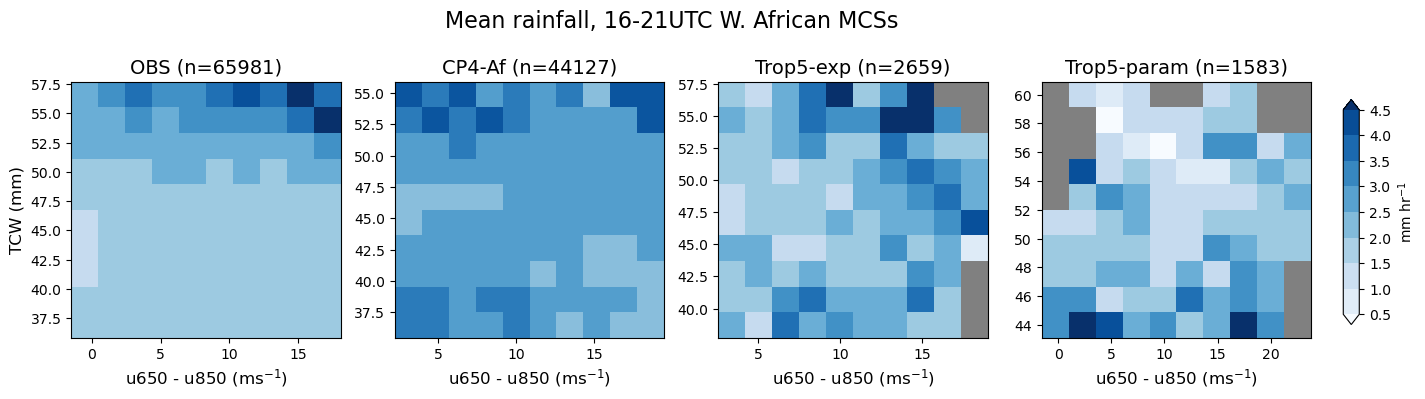

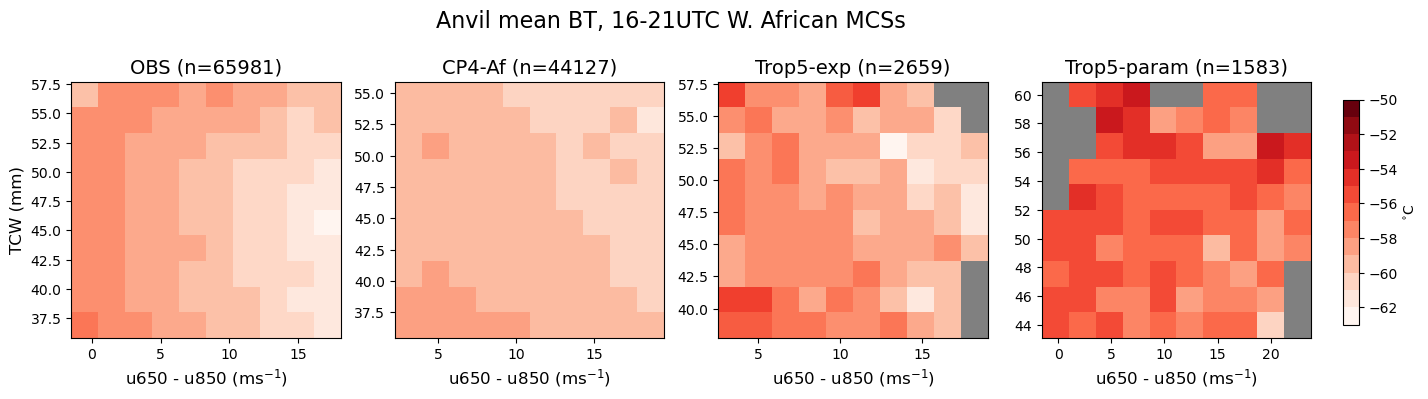

In [60]:
hierarchy_var_comparison(MCS_data_dict,"rain_mean",max_pcle=0.95,min_pcle=0.05)
hierarchy_var_comparison(MCS_data_dict,"tmean",max_pcle=0.95,min_pcle=0.05)#,save="S7a")

Text(0.535, 0.8, 'c)')

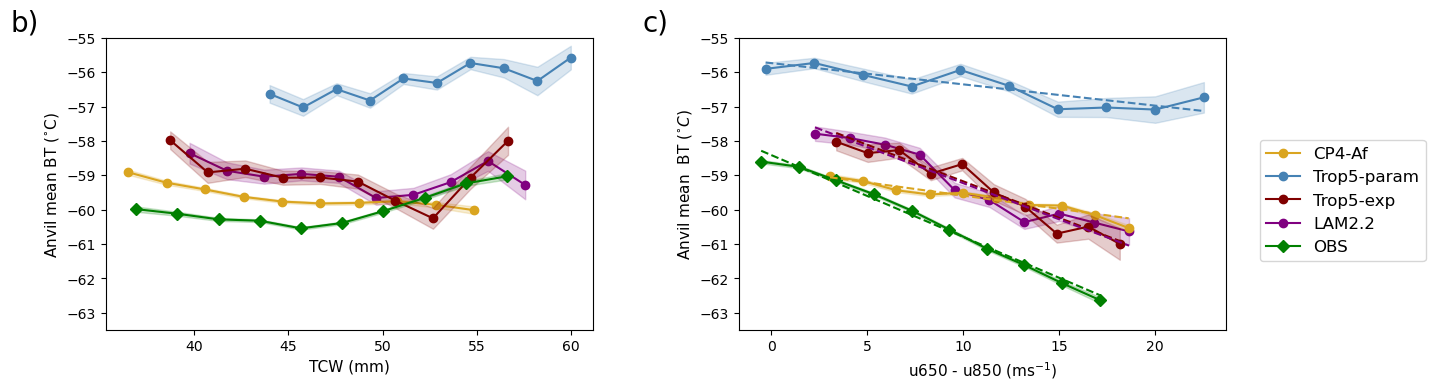

In [61]:
moist_var,shear_var="tcw","ushear650_850"
fig,ax=plt.subplots(1,2,figsize=(16,5),gridspec_kw={"wspace":0.3})
ax[0]=multi_fits(ax[0],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["OBS"]],
                 ["a","b","c","d","e"],"tmean",moist_var,shear_var,lobf=[0,0,0,0,0],cut_off=5,max_pcle=0.95,min_pcle=0.05)
ax[0].set_box_aspect(0.6)
ax[0].set_xlabel(r"TCW (mm)",fontsize=11)
ax[0].set_ylabel(r"Anvil mean BT ($^{\circ}$C)",fontsize=11)
ax[0].get_legend().remove()
ax[0].set_ylim([-63.5,-55])
#ax[0].set_title("Max w500 vs environmental shear",fontsize=14)
#ax[0].set_ylim([0,12000])
#ax[1].axhline(0,alpha=0.4,color="k")
ax[1]=multi_fits(ax[1],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"],MCS_data_dict["OBS"]],
                 ["a","b","c","d","e"],"tmean",shear_var,moist_var,lobf=[1,1,1,1,1],cut_off=5,max_pcle=0.95,min_pcle=0.05)
#ax[1].set_box_aspect(0.5)
ax[1].set_xlabel(r"u650 - u850 (ms$^{-1}$)",fontsize=11)
ax[1].set_ylabel(r"Anvil mean  BT ($^{\circ}C$)",fontsize=11)
#ax[1].set_title("Core buoyancy vs environmental shear",fontsize=14)
ax[1].set_box_aspect(0.6)
ax[1].get_legend().remove()
ax[1].set_ylim([-63.5,-55])
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='LAM2.2'),
                   Line2D([],[],color="green", marker="D", label='OBS')]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.2)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.03, 0.6))
plt.figtext(0.14,0.8,"b)",fontsize=20)
plt.figtext(0.535,0.8,"c)",fontsize=20)
#fig.savefig("figS7b.png",dpi=200,bbox_inches="tight",facecolor="white")

Text(0.545, 0.8, 'b)')

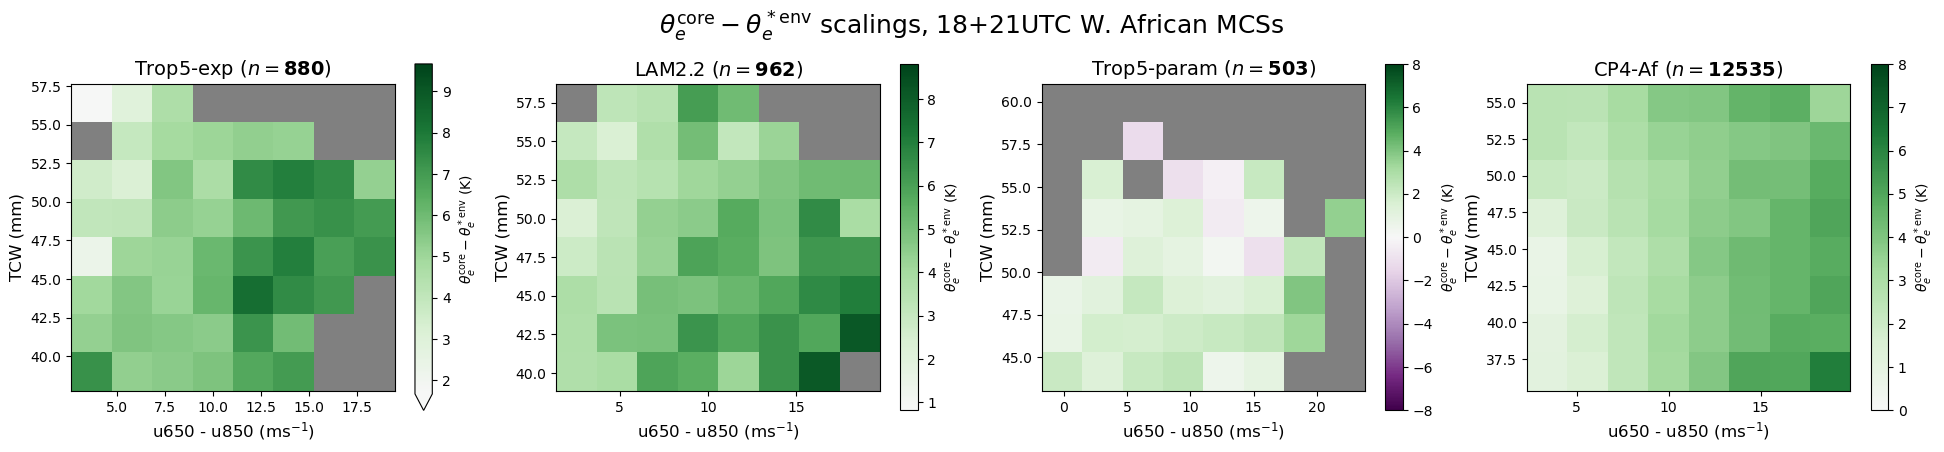

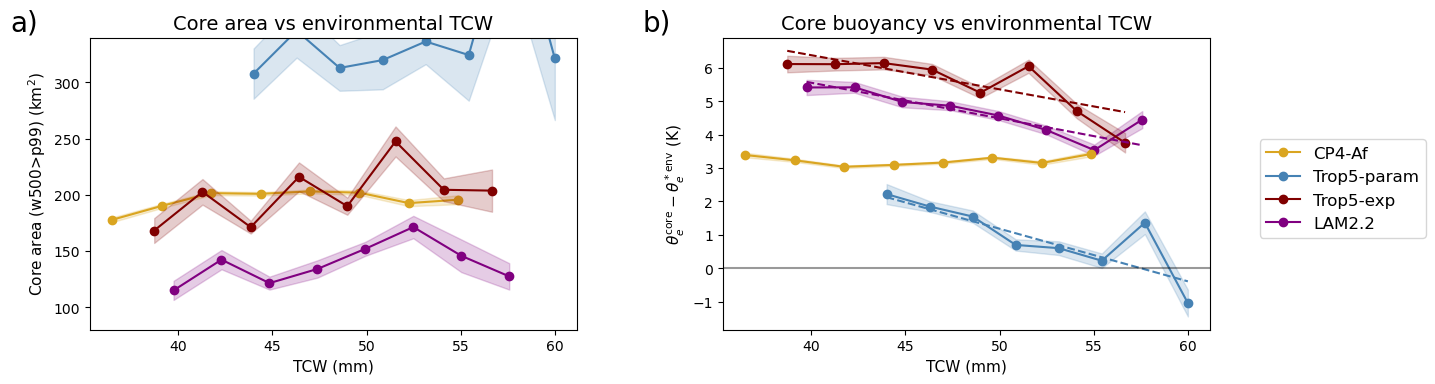

In [62]:
model_histograms([MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["CP4"]],
                 ["Trop5-exp","LAM2.2","Trop5-param","CP4-Af"],"theta_e_core_buoy",com_scale=8,cut_off=5,grid_spec=8,max_pcle=0.95,min_pcle=0.05)

moist_var,shear_var="tcw","ushear650_850"
fig,ax=plt.subplots(1,2,figsize=(16,5),gridspec_kw={"wspace":0.3})
#ax[0].set_ylim([0,12000])
ax[0]=multi_fits(ax[0],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"]],
                 ["a","b","c","d"],"area_w500_p99_core",moist_var,shear_var,lobf=None,grid_spec=8,max_pcle=0.95,min_pcle=0.05)
ax[0].set_box_aspect(0.6)
ax[0].set_xlabel(r"TCW (mm)",fontsize=11)
ax[0].set_ylabel(r"Core area (w500>p99) (km$^2$)",fontsize=11)
ax[0].get_legend().remove()
ax[0].set_ylim([80,340])
ax[0].set_title("Core area vs environmental TCW",fontsize=14)
ax[1]=multi_fits(ax[1],[MCS_data_dict["CP4"],MCS_data_dict["Channel_GAL9"],MCS_data_dict["Channel_RAL3"],MCS_data_dict["Lam"]],
                 ["a","b","c","d"],"theta_e_core_buoy",moist_var,shear_var,lobf=None,cut_off=5,grid_spec=8,max_pcle=0.95,min_pcle=0.05)
ax[1].set_box_aspect(0.6)
ax[1].set_xlabel(r"TCW (mm)",fontsize=11)
ax[1].set_ylabel(r"$\theta_e^{\rm core} - \theta_e^{\rm * env}$ (K)",fontsize=11)
ax[1].set_title("Core buoyancy vs environmental TCW",fontsize=14)
ax[1].get_legend().remove()
ax[1].axhline(0,alpha=0.4,color="k")
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='LAM2.2')]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.2)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.04, 0.6))
plt.figtext(0.15,0.8,"a)",fontsize=20)
plt.figtext(0.545,0.8,"b)",fontsize=20)
#fig.savefig("figS8.png",dpi=200,bbox_inches="tight",facecolor="white")

Text(0.545, 0.8, 'b)')

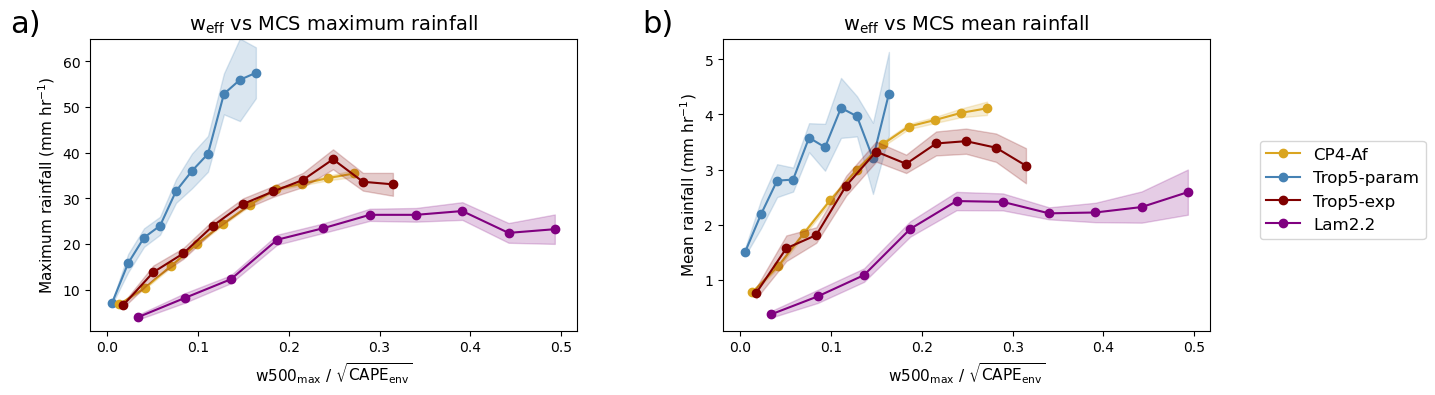

In [63]:
fig,ax=plt.subplots(1,2,figsize=(16,5),gridspec_kw={"wspace":0.3})
#ax[0].set_ylim([0,12000])
shear_var="ushear650_850"
ax[0].axhline(0,alpha=0.4,color="k")
ax[0]=multi_fits(ax[0],[MCS_data_dictw["CP4"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"]],
                 ["a","b","c","d"],"rain_max","w_eff",shear_var,lobf=[0,0,0,0],cut_off=5,max_pcle=0.95,min_pcle=0.05)
ax[0].set_box_aspect(0.6)
ax[0].set_xlabel(r"w500$_{\rm max}$ / $\sqrt{\rm CAPE_{env}}$",fontsize=11)
ax[0].set_ylabel(r"Maximum rainfall (mm hr$^{-1}$)",fontsize=11)
ax[0].set_title(r"w$_{\rm eff}$ vs MCS maximum rainfall",fontsize=14)
ax[0].set_ylim([1,65])
ax[0].get_legend().remove()
ax[1]=multi_fits(ax[1],[MCS_data_dictw["CP4"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"]],
                 ["a","b","c","d"],"rain_mean","w_eff",shear_var,lobf=[0,0,0,0],cut_off=5,max_pcle=0.95,min_pcle=0.05)
ax[1].set_box_aspect(0.6)
ax[1].set_xlabel(r"w500$_{\rm max}$ / $\sqrt{\rm CAPE_{env}}$",fontsize=11)
ax[1].set_ylabel(r"Mean rainfall (mm hr$^{-1}$)",fontsize=11)
ax[1].get_legend().remove()
ax[1].set_title(r"w$_{\rm eff}$ vs MCS mean rainfall",fontsize=14)
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='Lam2.2'),]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.2)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.04, 0.6))
plt.figtext(0.15,0.8,"a)",fontsize=22)
plt.figtext(0.545,0.8,"b)",fontsize=22)

Text(0.545, 0.8, 'b)')

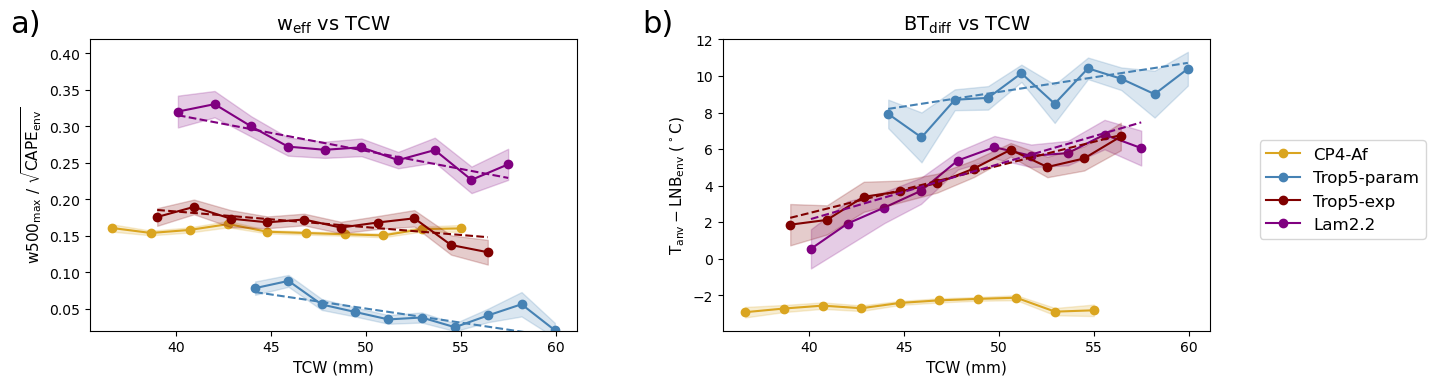

In [64]:
fig,ax=plt.subplots(1,2,figsize=(16,5),gridspec_kw={"wspace":0.3})
shear_var="ushear650_850"
#ax[0].set_ylim([0,12000])
ax[0].axhline(0,alpha=0.4,color="k")
ax[0]=multi_fits(ax[0],[MCS_data_dictw["CP4"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"]],
                 ["a","b","c","d"],"w_eff","tcw",shear_var,lobf=None,cut_off=5,max_pcle=0.95,min_pcle=0.05)
ax[0].set_box_aspect(0.6)
ax[0].set_xlabel(r"TCW (mm)",fontsize=11)
ax[0].set_ylabel(r"w500$_{\rm max}$ / $\sqrt{\rm CAPE_{env}}$",fontsize=11)
ax[0].set_title(r"w$_{\rm eff}$ vs TCW",fontsize=14)
ax[0].set_ylim([0.02,0.42])
ax[0].get_legend().remove()
ax[1]=multi_fits(ax[1],[MCS_data_dictw["CP4"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Lam"]],
                 ["a","b","c","d"],"btdiff","tcw",shear_var,lobf=None,cut_off=5,max_pcle=0.95,min_pcle=0.05)
ax[1].set_box_aspect(0.6)
ax[1].set_ylabel(r"$\rm T_{anv} - LNB_{env}$ ($^\circ$C)",fontsize=11)
ax[1].set_xlabel(r"TCW (mm)",fontsize=11)
ax[1].get_legend().remove()
ax[1].set_title(r"$\rm BT_{diff}$ vs TCW",fontsize=14)
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp'),
                   Line2D([],[],color="purple", marker="o", label='Lam2.2'),]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.2)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.04, 0.6))
plt.figtext(0.15,0.8,"a)",fontsize=22)
plt.figtext(0.545,0.8,"b)",fontsize=22)

Text(0.23, 0.75, 'b)')

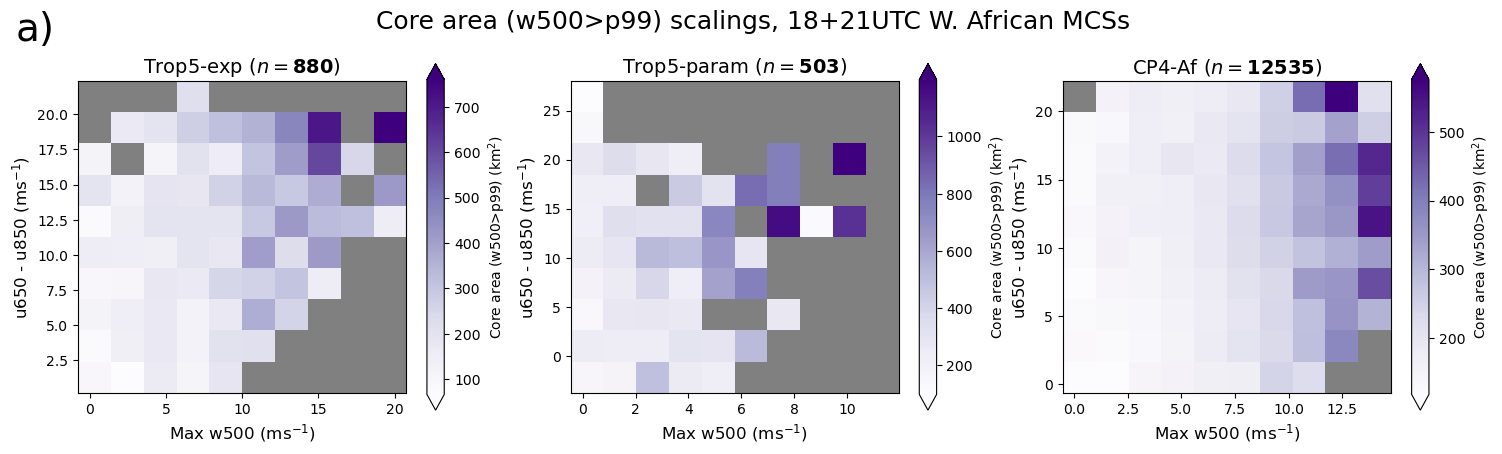

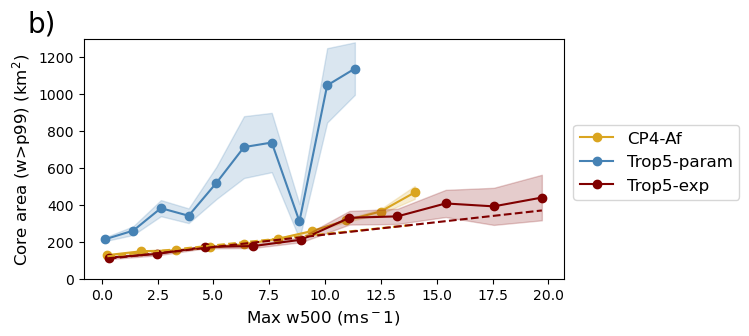

In [65]:
fig,axes=model_histograms([MCS_data_dictw["Channel_RAL3"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["CP4"]],["Trop5-exp","Trop5-param","CP4-Af"],"area_w500_p99_core",shear_var="max_w500",
                  moist_var="ushear650_850",com_scale=False,save=False,cut_off=2)
for ax in axes:
    ax.set_ylabel(r"u650 - u850 (ms$^{-1}$)",fontsize=12)
    ax.set_xlabel(r"Max w500 (ms$^{-1}$)",fontsize=12)
plt.figtext(0.09,0.93,"a)",fontsize=28)
shear_var="ushear650_850"
fig,ax=plt.subplots(1,figsize=(8,5))
ax=multi_fits(ax,[MCS_data_dictw["CP4"],MCS_data_dictw["Channel_GAL9"],MCS_data_dictw["Channel_RAL3"]],["a","b","c"],"area_w500_p99_core","max_w500",shear_var,lobf=[1,0,1],cut_off=5)
ax.set_box_aspect(0.5)
ax.set_xlabel(r"Max w500 (ms$^-1$)",fontsize=12)
ax.set_ylabel(r"Core area (w>p99) (km$^2$)",fontsize=12)
ax.get_legend().remove()
ax.set_ylim([0,1300])
legend_elements = [Line2D([],[],color="goldenrod", marker="o", label='CP4-Af'),
                   Line2D([],[],color="steelblue", marker="o", label='Trop5-param'),
                   Line2D([],[],color="maroon", marker="o", label='Trop5-exp')]
#fig.subplots_adjust(bottom=0.1)
fig.subplots_adjust(left=0.3)
fig.legend(handles=legend_elements, fontsize='12', bbox_to_anchor=(1.13, 0.58))
plt.figtext(0.23,0.75,"b)",fontsize=20)